<a href="https://colab.research.google.com/github/boskya/aai521-real-tile-asl-recognition/blob/main/asl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mediapipe opencv-python

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import tensorflow as tf
import os

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import preprocess_input

import cv2
import mediapipe as mp
import numpy as np
import tensorflow as tf
from collections import deque

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict


import glob
import pickle
import json

# Check GPU
print("GPU Available:", tf.config.list_physical_devices('GPU'))

/usr/local/lib/python3.12/dist-packages/jaxlib/plugin_support.py:71: RuntimeWarning: JAX plugin jax_cuda12_plugin version 0.7.2 is installed, but it is not compatible with the installed jaxlib version 0.7.1, so it will not be used.
  warnings.warn(


GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Set up project directory in Drive
project_dir = '/content/drive/MyDrive/ASL_Project'
!mkdir -p {project_dir}/data
!mkdir -p {project_dir}/models
!mkdir -p {project_dir}/checkpoints

%cd {project_dir}

Mounted at /content/drive
/content/drive/MyDrive/ASL_Project


In [13]:
# Check if dataset already exists
data_path = f'{project_dir}/data/asl_alphabet_train'

if not os.path.exists(data_path):
    print("Downloading dataset...")
    !curl -L -o {project_dir}/asl-alphabet.zip \
      https://www.kaggle.com/api/v1/datasets/download/grassknoted/asl-alphabet

    print("Extracting dataset...")
    !unzip -q {project_dir}/asl-alphabet.zip -d {project_dir}/data/

    print("Cleaning up zip file...")
    !rm {project_dir}/asl-alphabet.zip

    print("Dataset ready!")
else:
    print("Dataset already exists in Drive. Skipping download.")

# Set data directory
data_dir = f'{project_dir}/data/asl_alphabet_train/asl_alphabet_train'

Dataset already exists in Drive. Skipping download.


In [ ]:
!unzip /content/asl-alphabet.zip -d /content/asl_data

In [5]:
local_data_dir = '/content/asl_data/'
local_data_dir_train = '/content/asl_data/asl_alphabet_train/asl_alphabet_train'

Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']

Images per class:
A: 3000 images
B: 3000 images
C: 3000 images
D: 3000 images
E: 3000 images
F: 3000 images
G: 3000 images
H: 3000 images
I: 3000 images
J: 3000 images
K: 3000 images
L: 3000 images
M: 3000 images
N: 3000 images
O: 3080 images
P: 3000 images
Q: 3000 images
R: 3000 images
S: 3000 images
T: 3000 images
U: 3000 images
V: 3000 images
W: 3000 images
X: 3000 images
Y: 3000 images
Z: 3032 images
del: 3000 images
nothing: 3000 images
space: 3000 images


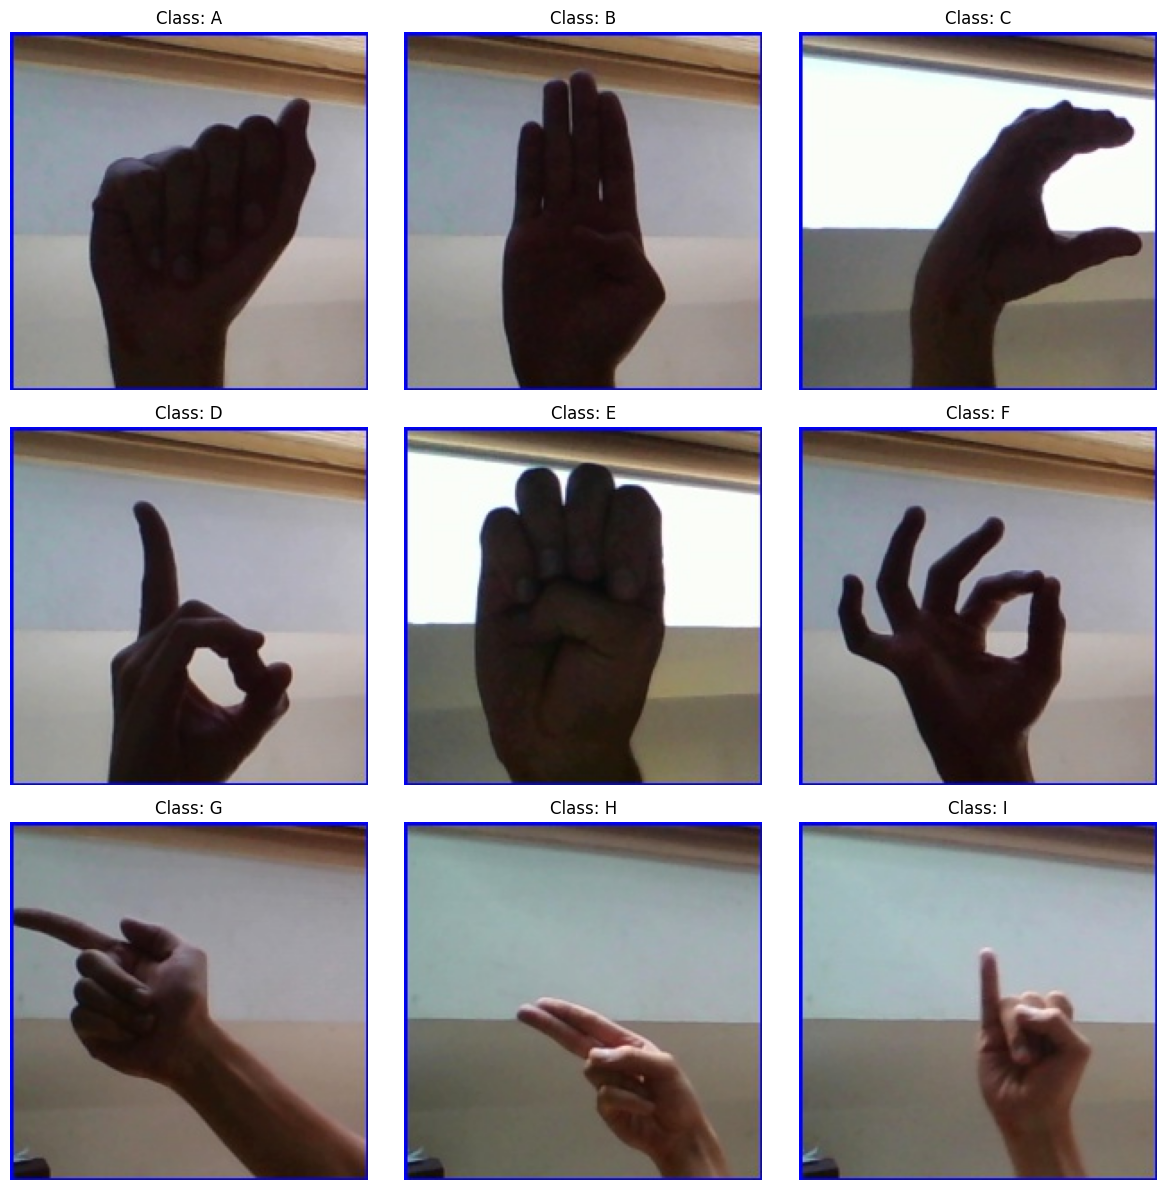

In [14]:
# Get classes
classes = sorted(os.listdir(local_data_dir_train))
print(f"Number of classes: {len(classes)}")
print(f"Classes: {classes}")

# Count images per class
print("\nImages per class:")
for cls in classes:
    count = len(os.listdir(os.path.join(data_dir, cls)))
    print(f"{cls}: {count} images")

# Visualize samples from different classes
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    if i < len(classes):
        cls = classes[i]
        cls_dir = os.path.join(data_dir, cls)
        img_name = os.listdir(cls_dir)[0]
        img_path = os.path.join(cls_dir, img_name)

        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"Class: {cls}")
        ax.axis('off')
plt.tight_layout()
plt.show()

# Model training

## Model 1: No data augmentation and no fine training

In [13]:
# Parameters
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = 29
EPOCHS = 15
NUM_CLASSES = len(classes)
actual_class_dir=local_data_dir_train

# ============================================================
# DATA GENERATORS
# ============================================================

print("\nSetting up data generators...")

# Use EfficientNet preprocessing in the generator
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = datagen.flow_from_directory(
    actual_class_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    actual_class_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {val_generator.samples}")

# Verify labels are correct
x_batch, y_batch = next(train_generator)
print(f"\nLabel verification:")
print(f"  Shape: {y_batch.shape}")
print(f"  Sum: {np.sum(y_batch[0])}")
if y_batch.shape[1] == NUM_CLASSES and abs(np.sum(y_batch[0]) - 1.0) < 0.01:
    print("✓ Labels are correct one-hot encoding")
else:
    print("✗ ERROR: Labels are incorrect!")


Setting up data generators...
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
✓ Training samples: 69600
✓ Validation samples: 17400

Label verification:
  Shape: (128, 29)
  Sum: 1.0
✓ Labels are correct one-hot encoding


In [16]:
def create_model_no_data_aug():
    # Load base model
  base_model = EfficientNetB0(
      weights='imagenet',
      input_shape=(IMG_SIZE, IMG_SIZE, 3),
      include_top=False
  )

  # Freeze base model for initial training
  base_model.trainable = False
  print(f"  Base model layers: {len(base_model.layers)} (all frozen)")

  # Build SIMPLE model WITHOUT data augmentation layer
  model = tf.keras.Sequential([
      base_model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(256, activation='relu'),
      tf.keras.layers.Dropout(0.3),
      tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
  ], name='ASL')

  # Compile
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

  print("✓ Model built successfully")

  return model


In [17]:
# Check for existing checkpoints
checkpoint_dir = 'checkpoints_not_aug'
checkpoint_files = sorted(glob.glob(f'{project_dir}/{checkpoint_dir}/*.h5') +
                          glob.glob(f'{project_dir}/{checkpoint_dir}/*.keras'))

if checkpoint_files:
    print("Found existing checkpoints:")
    for i, cp in enumerate(checkpoint_files[-5:]):  # Show last 5
        print(f"{i}: {os.path.basename(cp)}")

    # Load latest checkpoint
    latest_checkpoint = checkpoint_files[-1]
    print(f"\nLoading: {latest_checkpoint}")
    model = tf.keras.models.load_model(latest_checkpoint)

    # Continue training from this checkpoint
    try:
        # Extract epoch number from filename (format: asl_checkpoint_XX_0.XXXX.h5)
        epoch_part = os.path.basename(latest_checkpoint).split('_')[2]
        initial_epoch = int(epoch_part)
        print(f"Resuming from epoch {initial_epoch}")
    except:
        print("Could not parse epoch number, starting from epoch 0")
        initial_epoch = 0

else:
  print("\nNo checkpoints found. Building fresh model...")
  initial_epoch = 0

  model = create_model_no_data_aug()

# Display model summary
print("\nModel Summary:")
model.summary()
print(f"\nReady to train from epoch {initial_epoch}")


No checkpoints found. Building fresh model...
  Base model layers: 238 (all frozen)
✓ Model built successfully

Model Summary:


Model: "ASL"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,960 (16.73 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 4,049,571 (15.45 MB)


Ready to train from epoch 0


In [19]:
# Callbacks with checkpointing
checkpoint_path = f'{project_dir}/{checkpoint_dir}/asl_checkpoint_{{epoch:02d}}_{{val_accuracy:.4f}}.keras'

callbacks = [
    # Save best model
    ModelCheckpoint(
        f'{project_dir}/models/asl_model_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    # Save checkpoint every epoch
    ModelCheckpoint(
        checkpoint_path,
        save_freq='epoch',
        verbose=1
    ),
    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    # Reduce learning rate on plateau
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("\n" + "="*60)
print("Starting training with correct EfficientNet preprocessing")
print("="*60)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS,
    initial_epoch=initial_epoch,
    callbacks=callbacks,
    verbose=1
)

# Save final model and history
model.save(f'{project_dir}/models/asl_model_final.keras')
print("\n✓ Training complete! Model saved to Drive.")


if history:
    # Save as pickle
    with open(f'{project_dir}/{checkpoint_dir}/history.pkl', 'wb') as f:
        pickle.dump(history.history, f)

    # Also save as JSON (more portable)
    with open(f'{project_dir}/{checkpoint_dir}/history.json', 'w') as f:
        json.dump(history.history, f)

    print("✓ model 1 history saved")




Starting training with correct EfficientNet preprocessing
Epoch 1/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9873 - loss: 0.0414
Epoch 1: val_accuracy improved from -inf to 0.92011, saving model to /content/drive/MyDrive/ASL_Project/models/asl_model_best.keras

Epoch 1: saving model to /content/drive/MyDrive/ASL_Project/checkpoints_not_aug/asl_checkpoint_01_0.9201.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 133s 244ms/step - accuracy: 0.9873 - loss: 0.0414 - val_accuracy: 0.9201 - val_loss: 0.2707 - learning_rate: 5.0000e-04
Epoch 2/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9890 - loss: 0.0357
Epoch 2: val_accuracy did not improve from 0.92011

Epoch 2: saving model to /content/drive/MyDrive/ASL_Project/checkpoints_not_aug/asl_checkpoint_02_0.9194.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 131s 241ms/step - accuracy: 0.9890 - loss: 0.0357 - val_accuracy: 0.9194 - val_loss: 0.2398 - learning_rate: 5.0000e-04
Epoch 3/15
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accu

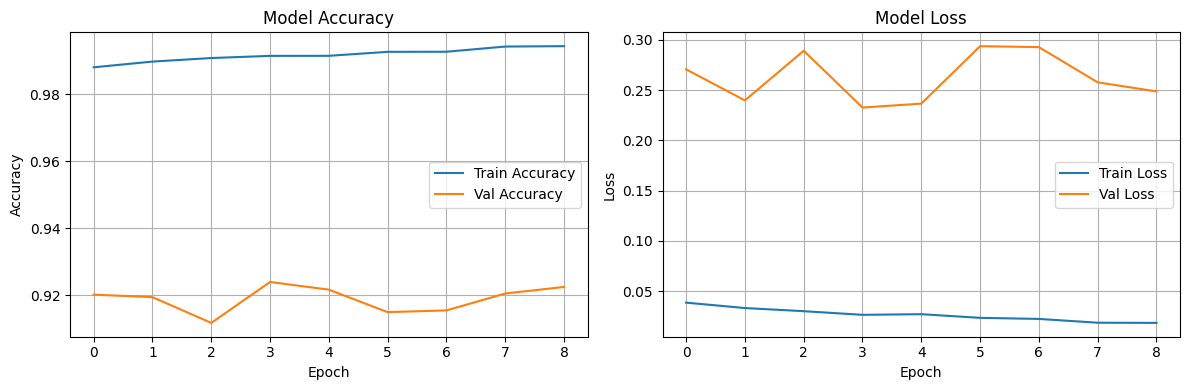


Final Training Accuracy: 0.9945
Final Validation Accuracy: 0.9224


In [23]:
# load history

with open(f'{project_dir}/{checkpoint_dir}/history.pkl','rb') as f:
    history = pickle.load(f)

# Plot accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Accuracy: {history['accuracy'][-1]:.4f}")
print(f"Final Validation Accuracy: {history['val_accuracy'][-1]:.4f}")

# Model 2: With fine tuning and data augmentation

In [24]:
# ============================================================
# WITH DATA AUGMENTATION AND FINE-TUNING
# ============================================================

# Clear session
tf.keras.backend.clear_session()

print("="*60)
print("RETRAIN WITH AUGMENTATION + FINE-TUNING")
print("="*60)

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 128
NUM_CLASSES = 29
STAGE1_EPOCHS = 10  # Train classifier only
STAGE2_EPOCHS = 10  # Fine-tune entire model

actual_class_dir = local_data_dir_train

# Create new directories
!mkdir -p {project_dir}/models_augmented
!mkdir -p {project_dir}/checkpoints_augmented

# ============================================================
# DATA AUGMENTATION
# ============================================================

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.15,
    brightness_range=[0.7, 1.3],
    fill_mode='constant',
    cval=255,
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    actual_class_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    actual_class_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

print(f"✓ Training samples: {train_generator.samples}")
print(f"✓ Validation samples: {val_generator.samples}")




RETRAIN WITH AUGMENTATION + FINE-TUNING
Found 69600 images belonging to 29 classes.
Found 17400 images belonging to 29 classes.
✓ Training samples: 69600
✓ Validation samples: 17400


In [26]:
# ============================================================
# CHECK FOR EXISTING CHECKPOINTS (RESUME LOGIC)
# ============================================================

checkpoint_files = sorted(glob.glob(f'{project_dir}/checkpoints_augmented/*.keras'))

if checkpoint_files:
    print("\n" + "="*60)
    print("FOUND EXISTING CHECKPOINTS - RESUMING")
    print("="*60)

    for i, cp in enumerate(checkpoint_files[-5:]):
        print(f"  {i}: {os.path.basename(cp)}")

    # Load latest checkpoint
    latest_checkpoint = checkpoint_files[-1]
    print(f"\nLoading: {os.path.basename(latest_checkpoint)}")
    model_aug = tf.keras.models.load_model(latest_checkpoint)

    # Determine which stage we're in and what epoch
    try:
        filename = os.path.basename(latest_checkpoint)

        # Check if it's stage1 or stage2
        if 'stage1' in filename:
            current_stage = 1
            # Extract epoch from format: asl_stage1_XX_0.XXXX.keras
            epoch_part = filename.split('_')[2]
            initial_epoch = int(epoch_part)
            print(f"✓ Resuming Stage 1 from epoch {initial_epoch}")

            # We're still in stage 1, so base should be frozen
            base_model = model.layers[0]
            base_model.trainable = False

            model_aug.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Continue stage 1
            stage = 1

        elif 'stage2' in filename or 'final' in filename:
            current_stage = 2
            epoch_part = filename.split('_')[2] if 'stage2' in filename else filename.split('_')[-2]
            initial_epoch = int(epoch_part)
            print(f"✓ Resuming Stage 2 from epoch {initial_epoch}")

            # We're in stage 2, base should be unfrozen
            base_model = model.layers[0]
            base_model.trainable = True

            model_aug.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )

            # Continue stage 2
            stage = 2
        else:
            print("Could not determine stage, starting fresh")
            stage = 0
            initial_epoch = 0

    except Exception as e:
        print(f"Error parsing checkpoint: {e}")
        print("Starting fresh")
        stage = 0
        initial_epoch = 0

else:
    print("\nNo checkpoints found. Building fresh model...")
    stage = 0
    initial_epoch = 0

    # Build model from scratch
    base_model = EfficientNetB0(
        weights='imagenet',
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False
    )

    base_model.trainable = False

    model_aug = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ], name='ASL_Augmented')

    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("✓ Model built (Stage 1: Frozen base)")

model_aug.summary()


No checkpoints found. Building fresh model...
✓ Model built (Stage 1: Frozen base)


Model: "ASL_Augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │         7,453 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,384,960 (16.73 MB)

 Trainable params: 335,389 (1.28 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [27]:

# ============================================================
# STAGE 1: TRAIN CLASSIFIER (or resume)
# ============================================================

if stage <= 1:  # If we haven't finished stage 1 yet
    print("\n" + "="*60)
    print(f"STAGE 1: Training from epoch {initial_epoch}/{STAGE1_EPOCHS}")
    print("="*60)

    callbacks_stage1 = [
        ModelCheckpoint(
            f'{project_dir}/models_augmented/asl_stage1_best.keras',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        ModelCheckpoint(
            f'{project_dir}/checkpoints_augmented/asl_stage1_{{epoch:02d}}_{{val_accuracy:.4f}}.keras',
            save_freq='epoch',
            verbose=1
        ),
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        )
    ]

    history_stage1 = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=STAGE1_EPOCHS,
        initial_epoch=initial_epoch if stage == 1 else 0,
        callbacks=callbacks_stage1,
        verbose=1
    )

    print(f"\nStage 1 complete!")
    print(f"Best val accuracy: {max(history_stage1.history['val_accuracy']):.4f}")

    # Reset for stage 2
    initial_epoch_stage2 = 0
else:
    print("\n✓ Stage 1 already complete, skipping to Stage 2")
    history_stage1 = None
    initial_epoch_stage2 = initial_epoch if stage == 2 else 0

# ============================================================
# STAGE 2: FINE-TUNE (or resume)
# ============================================================

print("\n" + "="*60)
print(f"STAGE 2: Fine-tuning from epoch {initial_epoch_stage2}/{STAGE2_EPOCHS}")
print("="*60)

# Unfreeze base model if not already done
base_model = model.layers[0]
if not base_model.trainable:
    base_model.trainable = True
    print(f"✓ Unfroze all {len(base_model.layers)} layers")

    # Recompile
    model_aug.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

callbacks_stage2 = [
    ModelCheckpoint(
        f'{project_dir}/models_augmented/asl_final_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ModelCheckpoint(
        f'{project_dir}/checkpoints_augmented/asl_stage2_{{epoch:02d}}_{{val_accuracy:.4f}}.keras',
        save_freq='epoch',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
]

history_stage2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=STAGE2_EPOCHS,
    initial_epoch=initial_epoch_stage2,
    callbacks=callbacks_stage2,
    verbose=1
)

model_aug.save(f'{project_dir}/models_augmented/asl_final.keras')

print("\n" + "="*60)
print("TRAINING COMPLETE")
print("="*60)
if history_stage1:
    print(f"Stage 1 best: {max(history_stage1.history['val_accuracy']):.4f}")
print(f"Stage 2 best: {max(history_stage2.history['val_accuracy']):.4f}")


# After Stage 1 completes
if history_stage1:
    # Save as pickle
    with open(f'{project_dir}/history_stage1.pkl', 'wb') as f:
        pickle.dump(history_stage1.history, f)

    # Also save as JSON (more portable)
    with open(f'{project_dir}/history_stage1.json', 'w') as f:
        json.dump(history_stage1.history, f)

    print("✓ Stage 1 history saved")

# After Stage 2 completes
with open(f'{project_dir}/history_stage2.pkl', 'wb') as f:
    pickle.dump(history_stage2.history, f)

with open(f'{project_dir}/history_stage2.json', 'w') as f:
    json.dump(history_stage2.history, f)

print("✓ Stage 2 history saved")



STAGE 1: Training from epoch 0/10


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9360 - loss: 0.1960
Epoch 1: val_accuracy improved from -inf to 0.92425, saving model to /content/drive/MyDrive/ASL_Project/models_augmented/asl_stage1_best.keras

Epoch 1: saving model to /content/drive/MyDrive/ASL_Project/checkpoints_augmented/asl_stage1_01_0.9243.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - accuracy: 0.9360 - loss: 0.1960 - val_accuracy: 0.9243 - val_loss: 0.2081
Epoch 2/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9575 - loss: 0.1306
Epoch 2: val_accuracy did not improve from 0.92425

Epoch 2: saving model to /content/drive/MyDrive/ASL_Project/checkpoints_augmented/asl_stage1_02_0.9195.keras
544/544 ━━━━━━━━━━━━━━━━━━━━ 815s 1s/step - accuracy: 0.9575 - loss: 0.1306 - val_accuracy: 0.9195 - val_loss: 0.2281
Epoch 3/10
544/544 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9606 - loss: 0.1183
Epoch 3: val_accuracy did not improve from 0.92425

Epoch 3: saving model to /content/drive/MyD

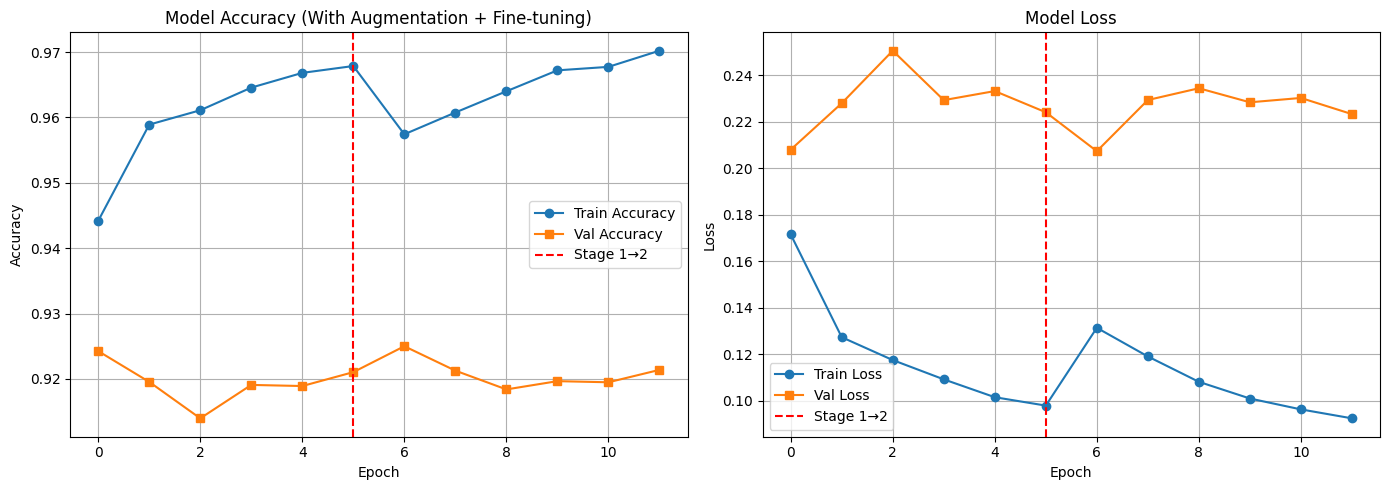

In [28]:
# ============================================================
# VISUALIZE
# ============================================================

import matplotlib.pyplot as plt

if history_stage1:
    all_acc = history_stage1.history['accuracy'] + history_stage2.history['accuracy']
    all_val_acc = history_stage1.history['val_accuracy'] + history_stage2.history['val_accuracy']
    all_loss = history_stage1.history['loss'] + history_stage2.history['loss']
    all_val_loss = history_stage1.history['val_loss'] + history_stage2.history['val_loss']

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(all_acc, label='Train Accuracy', marker='o')
    plt.plot(all_val_acc, label='Val Accuracy', marker='s')
    plt.axvline(x=len(history_stage1.history['accuracy'])-1, color='r', linestyle='--', label='Stage 1→2')
    plt.title('Model Accuracy (With Augmentation + Fine-tuning)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(all_loss, label='Train Loss', marker='o')
    plt.plot(all_val_loss, label='Val Loss', marker='s')
    plt.axvline(x=len(history_stage1.history['loss'])-1, color='r', linestyle='--', label='Stage 1→2')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    # Only stage 2 history
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_stage2.history['accuracy'], label='Train Accuracy', marker='o')
    plt.plot(history_stage2.history['val_accuracy'], label='Val Accuracy', marker='s')
    plt.title('Stage 2: Fine-tuning Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history_stage2.history['loss'], label='Train Loss', marker='o')
    plt.plot(history_stage2.history['val_loss'], label='Val Loss', marker='s')
    plt.title('Stage 2: Fine-tuning Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Cross test on another dataset (Ayuraj)

In [ ]:
!unzip /content/test_asl_dataset.zip -d /content/test_dataset

In [19]:
def test_on_dataset(model_path, ayuraj_classes, classes):
    # Load model
    model = tf.keras.models.load_model(model_path)
    # ============================================================
    # RUN INFERENCE
    # ============================================================

    results = []
    max_per_class = 100  # Limit for speed

    print("\n" + "="*60)
    print("RUNNING INFERENCE")
    print("="*60)

    for class_name in ayuraj_classes:
        # Convert lowercase to uppercase to match your model
        true_class = class_name.upper()

        if true_class not in classes:
            print(f"⚠ Skipping {class_name} - not in model classes")
            continue

        class_dir = os.path.join(ayuraj_test_dir, class_name)

        if not os.path.isdir(class_dir):
            continue

        # Get images
        image_files = [f for f in os.listdir(class_dir)
                      if f.endswith(('.jpg', '.png', '.jpeg', '.JPG', '.PNG'))][:max_per_class]

        class_correct = 0

        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)

            try:
                # Load and preprocess
                img = load_img(img_path, target_size=(224, 224))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0)
                img_array = preprocess_input(img_array)

                # Predict
                pred = model.predict(img_array, verbose=0)
                predicted_idx = np.argmax(pred)
                confidence = np.max(pred)
                predicted_class = classes[predicted_idx]

                is_correct = predicted_class == true_class
                if is_correct:
                    class_correct += 1

                results.append({
                    'true': true_class,
                    'predicted': predicted_class,
                    'confidence': confidence,
                    'correct': is_correct
                })

            except Exception as e:
                print(f"\n  Error processing {img_file}: {e}")
                continue

        class_acc = class_correct / len(image_files) if image_files else 0

    # ============================================================
    # RESULTS SUMMARY
    # ============================================================

    correct = sum(1 for r in results if r['correct'])
    total = len(results)
    accuracy = correct / total

    print("\n" + "="*60)
    print("CROSS-DATASET RESULTS")
    print("="*60)
    print(f"Total predictions: {total}")
    print(f"Correct: {correct}")
    print(f"Accuracy: {accuracy:.2%}")
    print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.2%}")

    # ============================================================
    # PER-CLASS ACCURACY
    # ============================================================

    class_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

    for r in results:
        class_stats[r['true']]['total'] += 1
        if r['correct']:
            class_stats[r['true']]['correct'] += 1

    print("\n" + "="*60)
    print("PER-CLASS ACCURACY")
    print("="*60)

    for cls in sorted(class_stats.keys()):
        stats = class_stats[cls]
        acc = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
        bar = "█" * int(acc * 40)
        print(f"{cls:8s}: {stats['correct']:3d}/{stats['total']:3d} ({acc:6.1%}) {bar}")

    # ============================================================
    # CONFUSION MATRIX
    # ============================================================

    true_labels = [r['true'] for r in results]
    pred_labels = [r['predicted'] for r in results]
    unique_classes = sorted(set(true_labels))

    cm = confusion_matrix(true_labels, pred_labels, labels=unique_classes)

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=unique_classes, yticklabels=unique_classes,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - Ayuraj Dataset\nAccuracy: {accuracy:.1%}', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ============================================================
    # MOST CONFUSED PAIRS
    # ============================================================

    print("\n" + "="*60)
    print("MOST CONFUSED SIGN PAIRS")
    print("="*60)

    confusion_pairs = []
    for i, true_cls in enumerate(unique_classes):
        for j, pred_cls in enumerate(unique_classes):
            if i != j and cm[i, j] > 0:
                confusion_pairs.append((true_cls, pred_cls, cm[i, j]))

    confusion_pairs.sort(key=lambda x: x[2], reverse=True)

    if confusion_pairs:
        print("\nTop 15 misclassifications:")
        for rank, (true_cls, pred_cls, count) in enumerate(confusion_pairs[:15], 1):
            pct = count / class_stats[true_cls]['total'] * 100
            print(f"{rank:2d}. {true_cls} → {pred_cls}: {count:3d} times ({pct:.1f}%)")

    # ============================================================
    # SAMPLE MISCLASSIFICATIONS
    # ============================================================

    errors = [r for r in results if not r['correct']]

    print(f"\n{len(errors)} total misclassifications ({len(errors)/total*100:.1f}%)")
    print("\nSample errors (first 10):")
    for err in errors[:10]:
        print(f"  True: {err['true']:8s} → Predicted: {err['predicted']:8s} ({err['confidence']:.1%})")

    # ============================================================
    # VISUALIZE PREDICTIONS
    # ============================================================

    print("\nGenerating visualization...")

    fig, axes = plt.subplots(4, 4, figsize=(16, 16))
    axes = axes.flatten()

    sample_idx = 0

    for class_name in ayuraj_classes[:4]:  # First 4 classes
        true_class = class_name.upper()

        if true_class not in classes:
            continue

        class_dir = os.path.join(ayuraj_test_dir, class_name)
        images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))][:4]

        for img_file in images:
            if sample_idx >= 16:
                break

            img_path = os.path.join(class_dir, img_file)

            # Load
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_display = img_array.astype('uint8')

            # Predict
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            pred = model.predict(img_array, verbose=0)
            predicted_class = classes[np.argmax(pred)]
            confidence = np.max(pred)

            # Display
            axes[sample_idx].imshow(img_display)
            color = 'green' if predicted_class == true_class else 'red'
            axes[sample_idx].set_title(
                f"True: {true_class}\nPred: {predicted_class}\n({confidence:.1%})",
                color=color, fontsize=10, fontweight='bold'
            )
            axes[sample_idx].axis('off')

            sample_idx += 1

    plt.tight_layout()
    plt.suptitle('Ayuraj Dataset - Sample Predictions', fontsize=16, y=1.01)
    plt.show()


CROSS-DATASET EVALUATION - AYURAJ ASL DATASET

Ayuraj dataset structure:

RUNNING INFERENCE
⚠ Skipping .DS_Store - not in model classes

CROSS-DATASET RESULTS
Total predictions: 1815
Correct: 420
Accuracy: 23.14%
Average confidence: 78.81%

PER-CLASS ACCURACY
A       :   9/ 70 ( 12.9%) █████
B       :  40/ 70 ( 57.1%) ██████████████████████
C       :  45/ 70 ( 64.3%) █████████████████████████
D       :   0/ 70 (  0.0%) 
E       :  22/ 70 ( 31.4%) ████████████
F       :   0/ 70 (  0.0%) 
G       :   1/ 70 (  1.4%) 
H       :   2/ 70 (  2.9%) █
I       :  65/ 70 ( 92.9%) █████████████████████████████████████
J       :  17/ 70 ( 24.3%) █████████
K       :   0/ 70 (  0.0%) 
L       :   0/ 70 (  0.0%) 
M       :   0/ 70 (  0.0%) 
N       :   0/ 70 (  0.0%) 
O       :  69/ 70 ( 98.6%) ███████████████████████████████████████
P       :  33/ 70 ( 47.1%) ██████████████████
Q       :   0/ 70 (  0.0%) 
R       :   0/ 70 (  0.0%) 
S       :   0/ 70 (  0.0%) 
T       :  31/ 65 ( 47.7%) █████████████

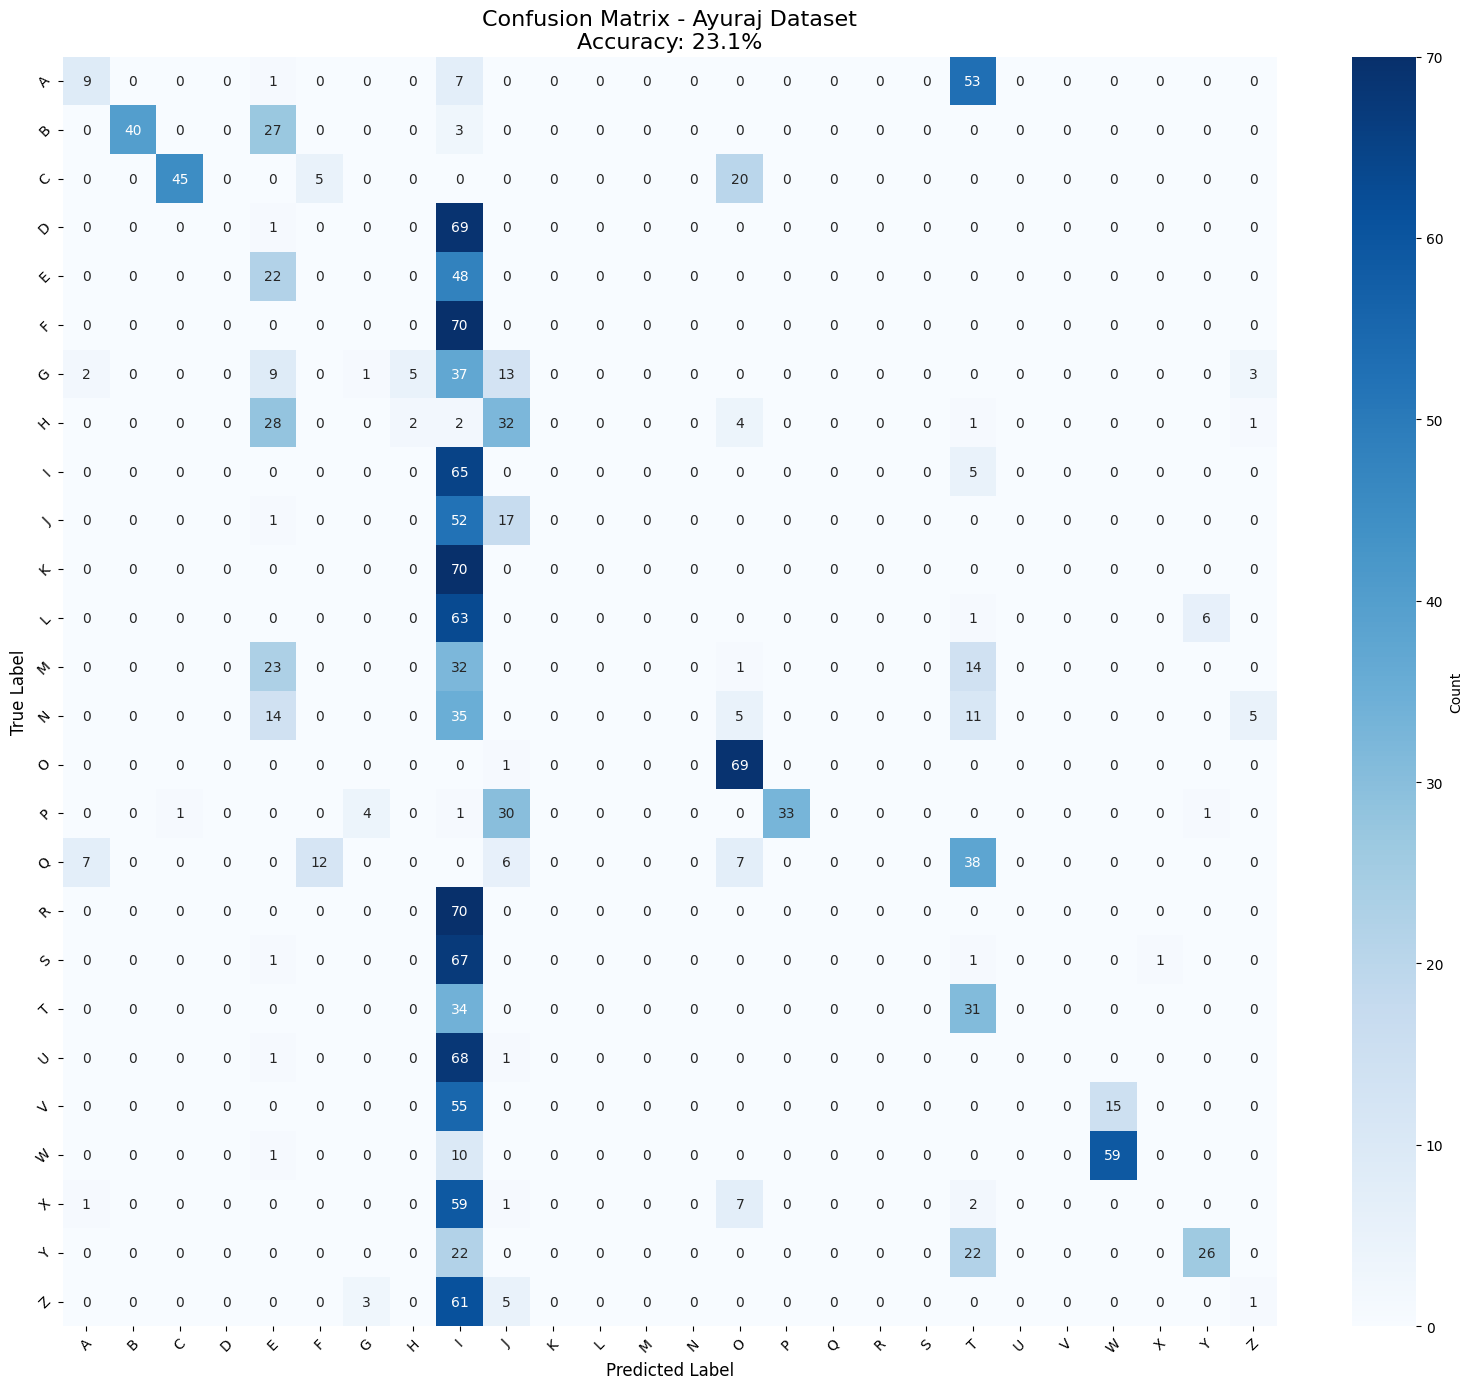


MOST CONFUSED SIGN PAIRS

Top 15 misclassifications:
 1. F → I:  70 times (100.0%)
 2. K → I:  70 times (100.0%)
 3. R → I:  70 times (100.0%)
 4. D → I:  69 times (98.6%)
 5. U → I:  68 times (97.1%)
 6. S → I:  67 times (95.7%)
 7. L → I:  63 times (90.0%)
 8. Z → I:  61 times (87.1%)
 9. X → I:  59 times (84.3%)
10. V → I:  55 times (78.6%)
11. A → T:  53 times (75.7%)
12. J → I:  52 times (74.3%)
13. E → I:  48 times (68.6%)
14. Q → T:  38 times (54.3%)
15. G → I:  37 times (52.9%)

1395 total misclassifications (76.9%)

Sample errors (first 10):
  True: A        → Predicted: T        (89.6%)
  True: A        → Predicted: T        (99.9%)
  True: A        → Predicted: I        (72.2%)
  True: A        → Predicted: T        (67.3%)
  True: A        → Predicted: T        (84.5%)
  True: A        → Predicted: T        (72.2%)
  True: A        → Predicted: T        (75.8%)
  True: A        → Predicted: T        (81.1%)
  True: A        → Predicted: T        (51.5%)
  True: A        → 

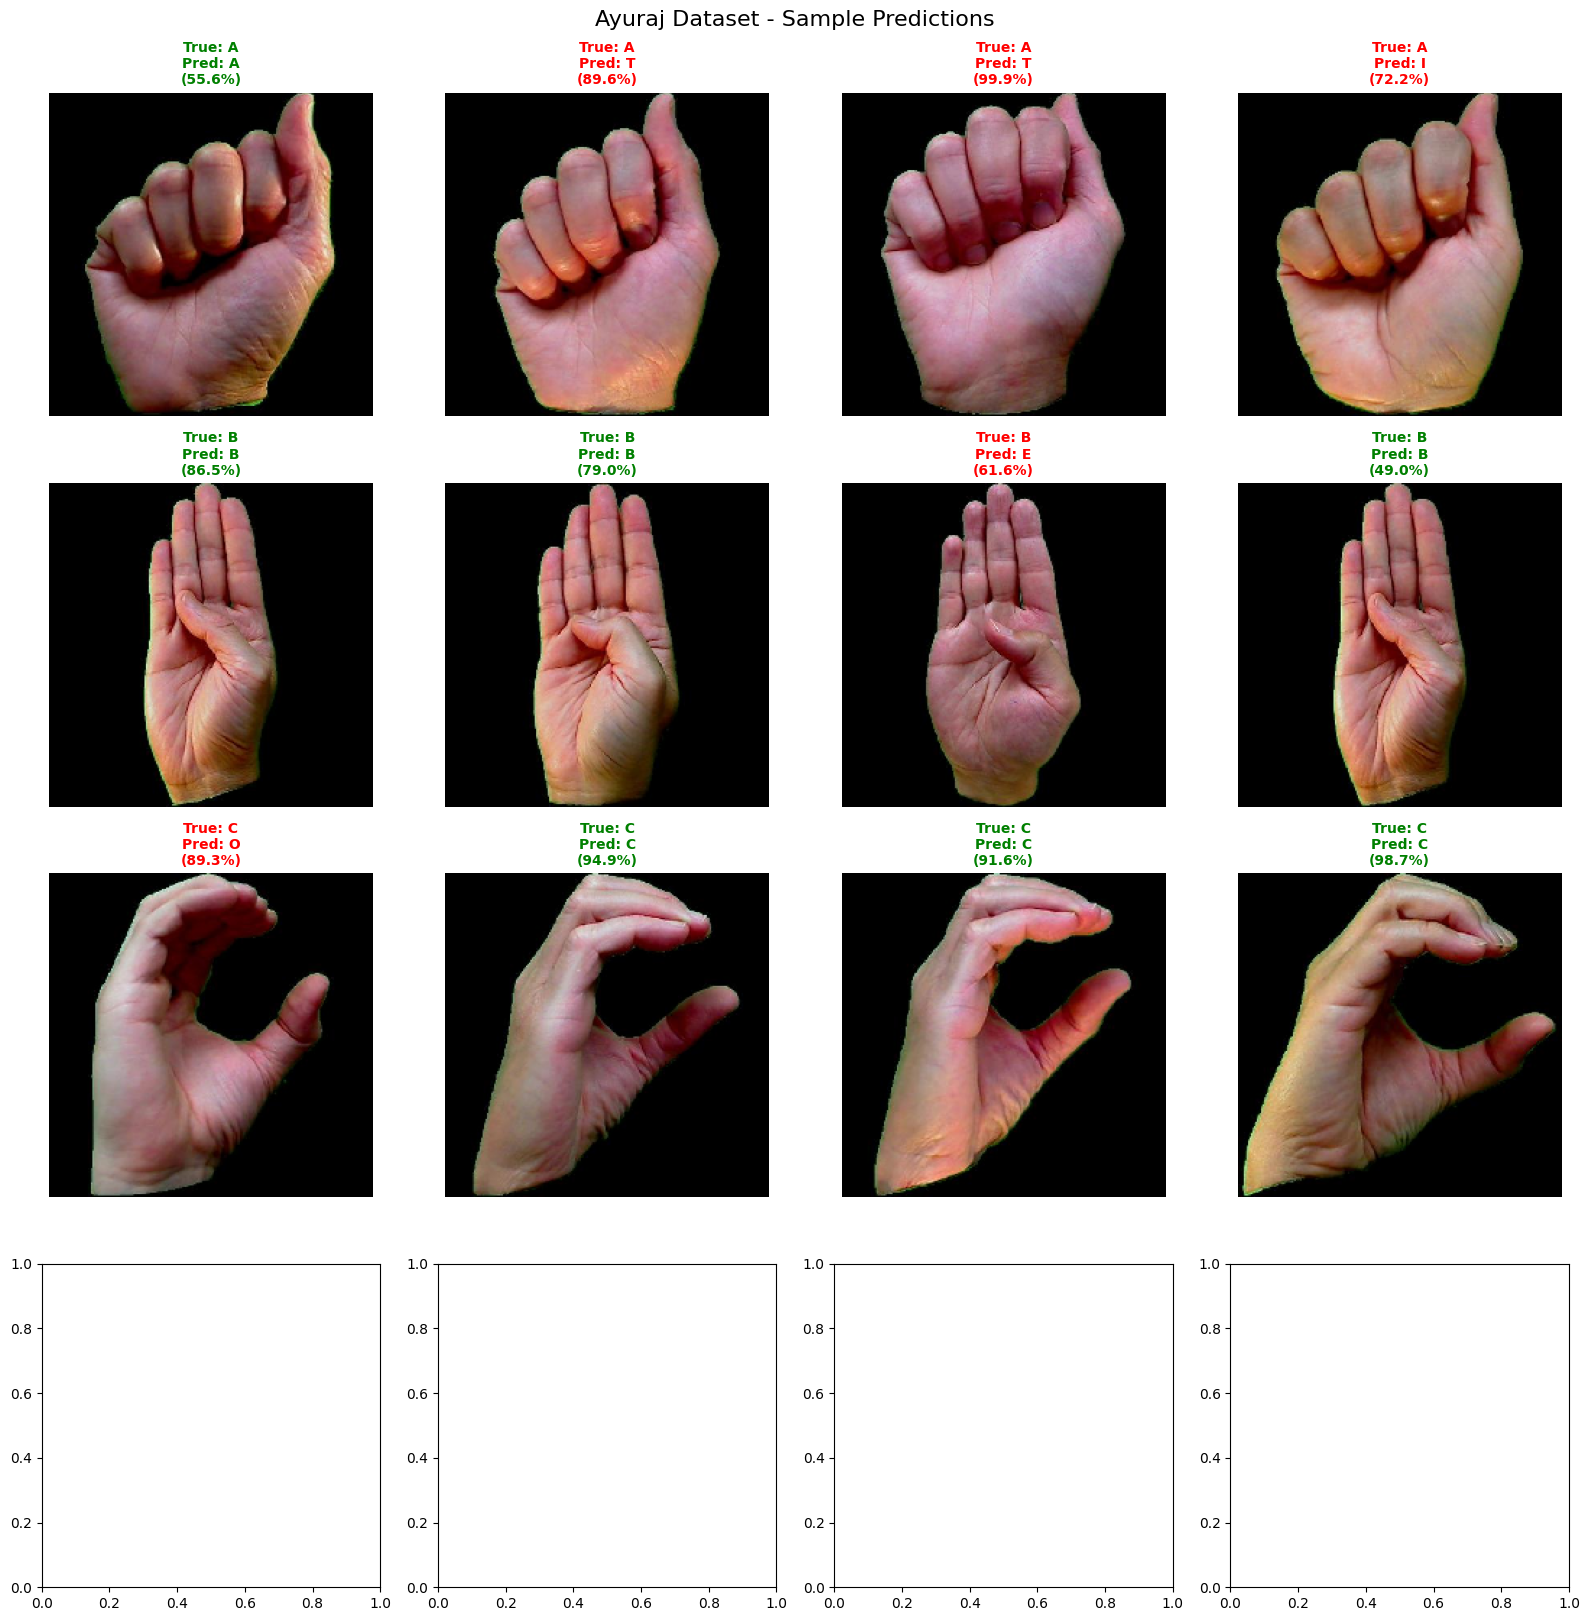

In [20]:
# ============================================================
# TEST ON AYURAJ DATASET with Model 1
# ============================================================


print("="*60)
print("CROSS-DATASET EVALUATION - AYURAJ ASL DATASET")
print("="*60)

# Paths
ayuraj_test_dir = '/content/test_dataset/test_asl_dataset'
model_path = f'{project_dir}/models/asl_model_best.keras'

# Check Ayuraj dataset structure
print(f"\nAyuraj dataset structure:")
ayuraj_classes = sorted(os.listdir(ayuraj_test_dir))


test_on_dataset(model_path, ayuraj_classes, classes)


CROSS-DATASET EVALUATION - AYURAJ ASL DATASET

Ayuraj dataset structure:


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 432 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))



RUNNING INFERENCE
⚠ Skipping .DS_Store - not in model classes

CROSS-DATASET RESULTS
Total predictions: 1815
Correct: 518
Accuracy: 28.54%
Average confidence: 71.57%

PER-CLASS ACCURACY
A       :   8/ 70 ( 11.4%) ████
B       :  16/ 70 ( 22.9%) █████████
C       :  41/ 70 ( 58.6%) ███████████████████████
D       :   0/ 70 (  0.0%) 
E       :  47/ 70 ( 67.1%) ██████████████████████████
F       :   0/ 70 (  0.0%) 
G       :   1/ 70 (  1.4%) 
H       :   0/ 70 (  0.0%) 
I       :  58/ 70 ( 82.9%) █████████████████████████████████
J       :  22/ 70 ( 31.4%) ████████████
K       :   0/ 70 (  0.0%) 
L       :   2/ 70 (  2.9%) █
M       :   0/ 70 (  0.0%) 
N       :   0/ 70 (  0.0%) 
O       :  59/ 70 ( 84.3%) █████████████████████████████████
P       :  53/ 70 ( 75.7%) ██████████████████████████████
Q       :   0/ 70 (  0.0%) 
R       :   0/ 70 (  0.0%) 
S       :  14/ 70 ( 20.0%) ████████
T       :  55/ 65 ( 84.6%) █████████████████████████████████
U       :   0/ 70 (  0.0%) 
V       :   2

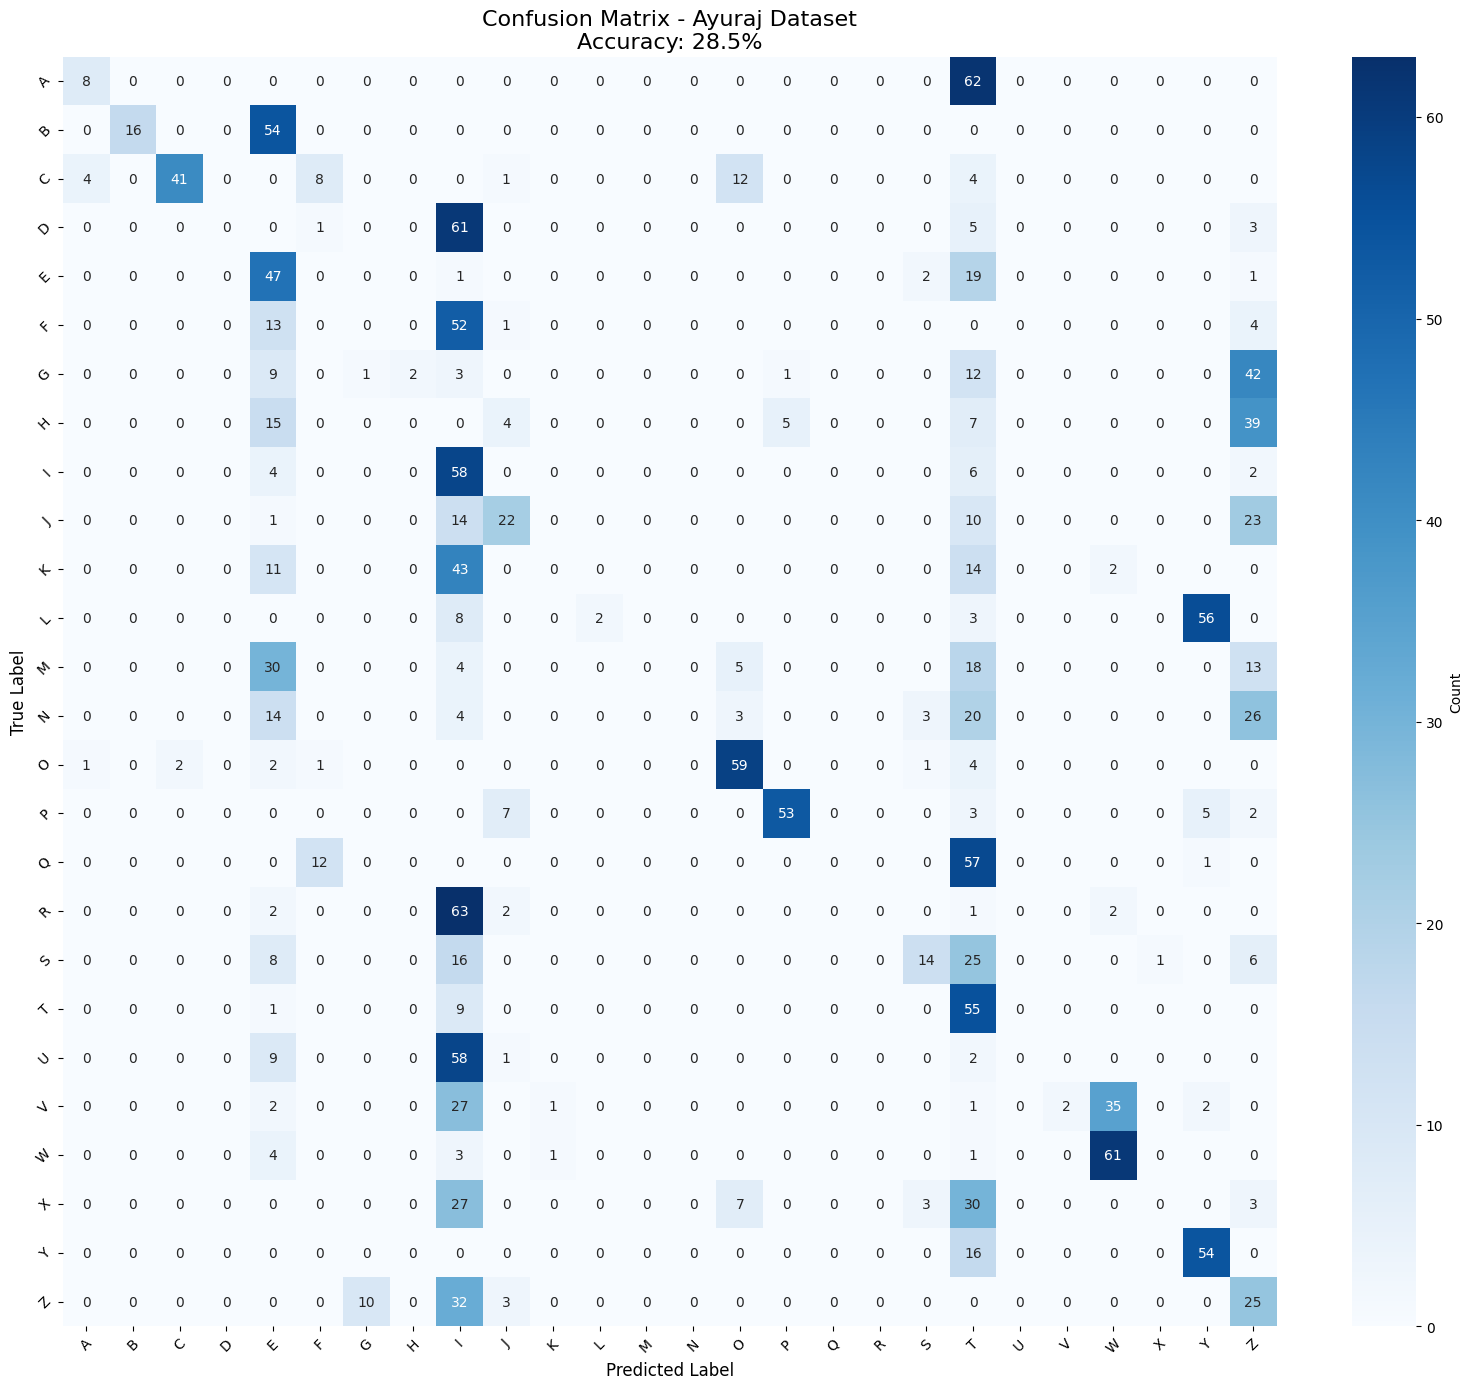


MOST CONFUSED SIGN PAIRS

Top 15 misclassifications:
 1. R → I:  63 times (90.0%)
 2. A → T:  62 times (88.6%)
 3. D → I:  61 times (87.1%)
 4. U → I:  58 times (82.9%)
 5. Q → T:  57 times (81.4%)
 6. L → Y:  56 times (80.0%)
 7. B → E:  54 times (77.1%)
 8. F → I:  52 times (74.3%)
 9. K → I:  43 times (61.4%)
10. G → Z:  42 times (60.0%)
11. H → Z:  39 times (55.7%)
12. V → W:  35 times (50.0%)
13. Z → I:  32 times (45.7%)
14. M → E:  30 times (42.9%)
15. X → T:  30 times (42.9%)

1297 total misclassifications (71.5%)

Sample errors (first 10):
  True: A        → Predicted: T        (53.2%)
  True: A        → Predicted: T        (87.2%)
  True: A        → Predicted: T        (99.9%)
  True: A        → Predicted: T        (88.0%)
  True: A        → Predicted: T        (93.3%)
  True: A        → Predicted: T        (83.0%)
  True: A        → Predicted: T        (68.2%)
  True: A        → Predicted: T        (78.5%)
  True: A        → Predicted: T        (89.8%)
  True: A        → Pre

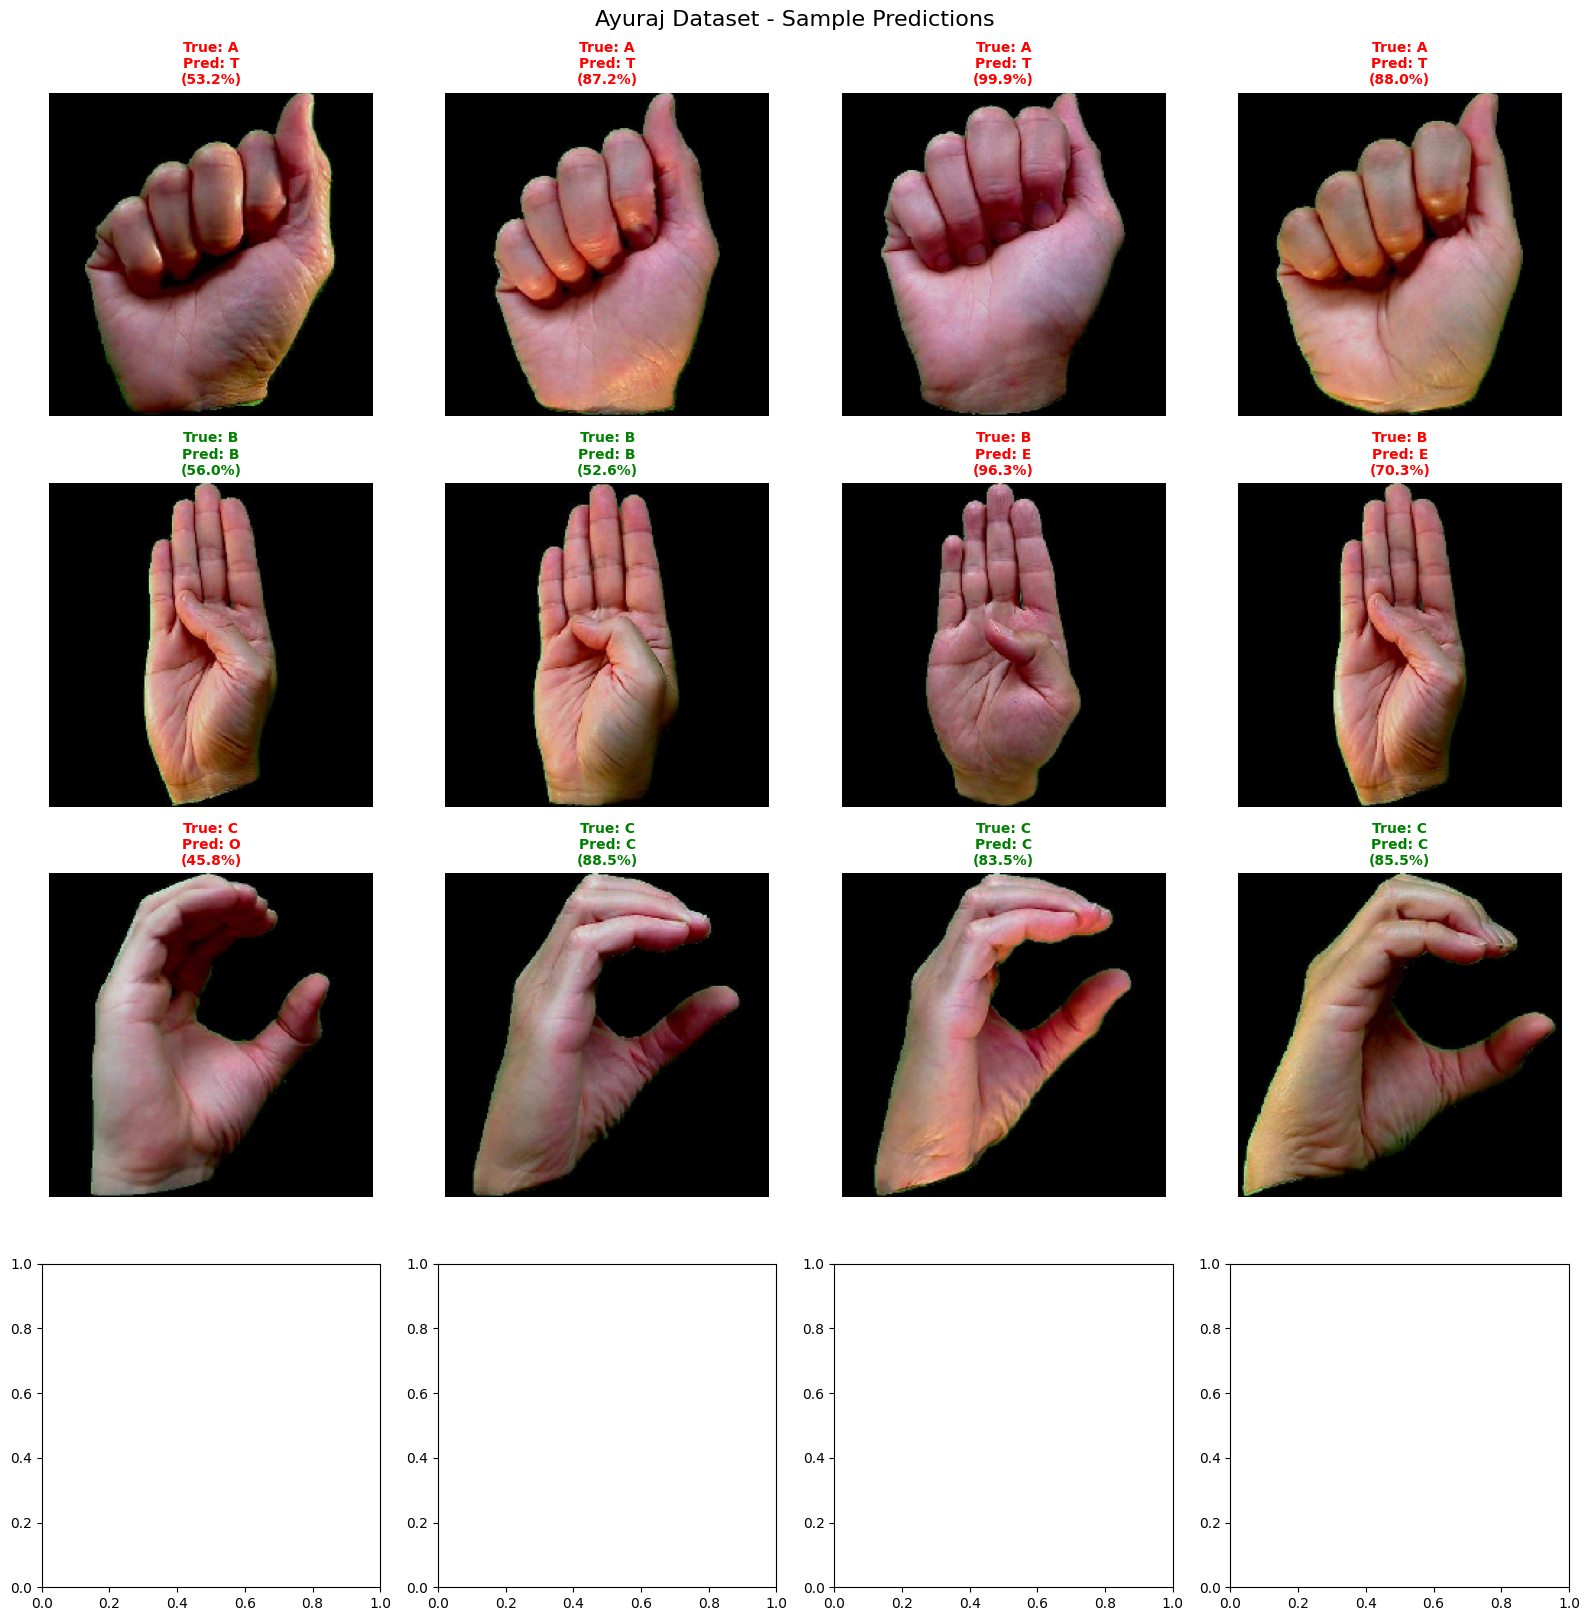

In [21]:
# ============================================================
# TEST ON AYURAJ DATASET with Model 2
# ============================================================


print("="*60)
print("CROSS-DATASET EVALUATION - AYURAJ ASL DATASET")
print("="*60)

# Paths
ayuraj_test_dir = '/content/test_dataset/test_asl_dataset'
model_path = f'{project_dir}/models_augmented/asl_final_best.keras'

# Check Ayuraj dataset structure
print(f"\nAyuraj dataset structure:")
ayuraj_classes = sorted(os.listdir(ayuraj_test_dir))


test_on_dataset(model_path, ayuraj_classes, classes)

# Real time web cam inference

In [ ]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

print("✓ MediaPipe Hands initialized")

✓ MediaPipe Hands initialized


In [ ]:
def preprocess_hand_region(hand_region):
    """
    Preprocess hand region for model prediction
    """
    # Resize to model input size
    img_resized = cv2.resize(hand_region, (224, 224))

    # Convert BGR to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Add batch dimension
    img_array = np.expand_dims(img_rgb, axis=0)

    # Apply EfficientNet preprocessing
    img_preprocessed = tf.keras.applications.efficientnet.preprocess_input(img_array)

    return img_preprocessed

def get_hand_bbox(hand_landmarks, frame_width, frame_height, padding=30):
    """
    Get bounding box around hand landmarks with padding
    """
    # Get all landmark coordinates
    x_coords = [landmark.x * frame_width for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y * frame_height for landmark in hand_landmarks.landmark]

    # Calculate bounding box with padding
    x_min = max(0, int(min(x_coords)) - padding)
    x_max = min(frame_width, int(max(x_coords)) + padding)
    y_min = max(0, int(min(y_coords)) - padding)
    y_max = min(frame_height, int(max(y_coords)) + padding)

    return x_min, y_min, x_max, y_max

print("✓ Preprocessing functions ready")

✓ Preprocessing functions ready


In [ ]:
class TemporalSmoother:
    """
    Smooth predictions over time using majority voting
    """
    def __init__(self, window_size=10):
        self.window_size = window_size
        self.predictions = deque(maxlen=window_size)

    def add_prediction(self, prediction):
        self.predictions.append(prediction)

    def get_smoothed_prediction(self):
        if len(self.predictions) == 0:
            return None

        from collections import Counter
        counts = Counter(self.predictions)
        return counts.most_common(1)[0][0]

    def reset(self):
        self.predictions.clear()

smoother = TemporalSmoother(window_size=10)
print("✓ Temporal smoother initialized")

✓ Temporal smoother initialized


In [14]:
# ============================================================
# REAL-TIME WEBCAM INFERENCE IN GOOGLE COLAB
# ============================================================

from IPython.display import display, Javascript, Image as IPImage
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def webcam_inference():
    """
    Real-time webcam inference in Colab
    """
    print("="*60)
    print("WEBCAM ASL RECOGNITION")
    print("="*60)
    print("Instructions:")
    print("- Allow camera access when prompted")
    print("- Show ASL signs to the camera")
    print("- Predictions update in real-time")
    print("- Run the cell again to capture another frame")
    print("="*60)

    # JavaScript to access webcam
    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Let user see themselves
            await new Promise((resolve) => setTimeout(resolve, 2000));

            // Capture frame
            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', 0.8);

            // Stop stream
            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')

    display(js)

    # Capture image from webcam
    data = eval_js('takePhoto()')

    # Decode image
    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary))
    img_array = np.array(img)

    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

    # Process with MediaPipe
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks
            mp_drawing.draw_landmarks(
                img_rgb,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )

            # Get bounding box
            h, w = img_bgr.shape[:2]
            x_min, y_min, x_max, y_max = get_hand_bbox(hand_landmarks, w, h, padding=50)

            # Draw bbox
            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

            # Extract hand region
            hand_region = img_bgr[y_min:y_max, x_min:x_max]

            if hand_region.size > 0:
                # Preprocess
                processed = preprocess_hand_region(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                predicted_class = classes[predicted_idx]

                # Add prediction to temporal smoother
                if confidence > 0.7:
                    smoother.add_prediction(predicted_class)
                smoothed_prediction = smoother.get_smoothed_prediction()

                # Add text to image
                cv2.putText(img_rgb, f"Raw: {predicted_class} ({confidence:.1%})",
                           (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                if smoothed_prediction:
                    cv2.putText(img_rgb, f"Smoothed: {smoothed_prediction}",
                               (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

                # Display result
                fig, axes = plt.subplots(1, 2, figsize=(16, 8))

                axes[0].imshow(img_rgb)
                axes[0].set_title(f"Prediction: {predicted_class} ({confidence:.1%})",
                                 fontsize=14, fontweight='bold')
                axes[0].axis('off')

                axes[1].imshow(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                axes[1].set_title("Extracted Hand Region", fontsize=14)
                axes[1].axis('off')

                plt.tight_layout()
                plt.show()

                # Print results
                print(f"\n{'='*60}")
                print(f"RAW PREDICTION: {predicted_class}")
                print(f"CONFIDENCE: {confidence:.2%}")
                if smoothed_prediction:
                    print(f"SMOOTHED: {smoothed_prediction}")
                print(f"{'='*60}")

                # Top 5
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for rank, idx in enumerate(top_5_idx, 1):
                    bar = "█" * int(prediction[0][idx] * 50)
                    print(f"  {rank}. {classes[idx]:8s} {prediction[0][idx]:6.2%} {bar}")
    else:
        print("✗ No hand detected")
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title("No hand detected", fontsize=16, color='red')
        plt.axis('off')
        plt.show()

print("✓ Webcam inference function ready")
print("\nTo capture and predict from webcam, run:")
print("  webcam_inference()")

✓ Webcam inference function ready

To capture and predict from webcam, run:
  webcam_inference()


WEBCAM ASL RECOGNITION
Instructions:
- Allow camera access when prompted
- Show ASL signs to the camera
- Predictions update in real-time
- Run the cell again to capture another frame


<IPython.core.display.Javascript object>

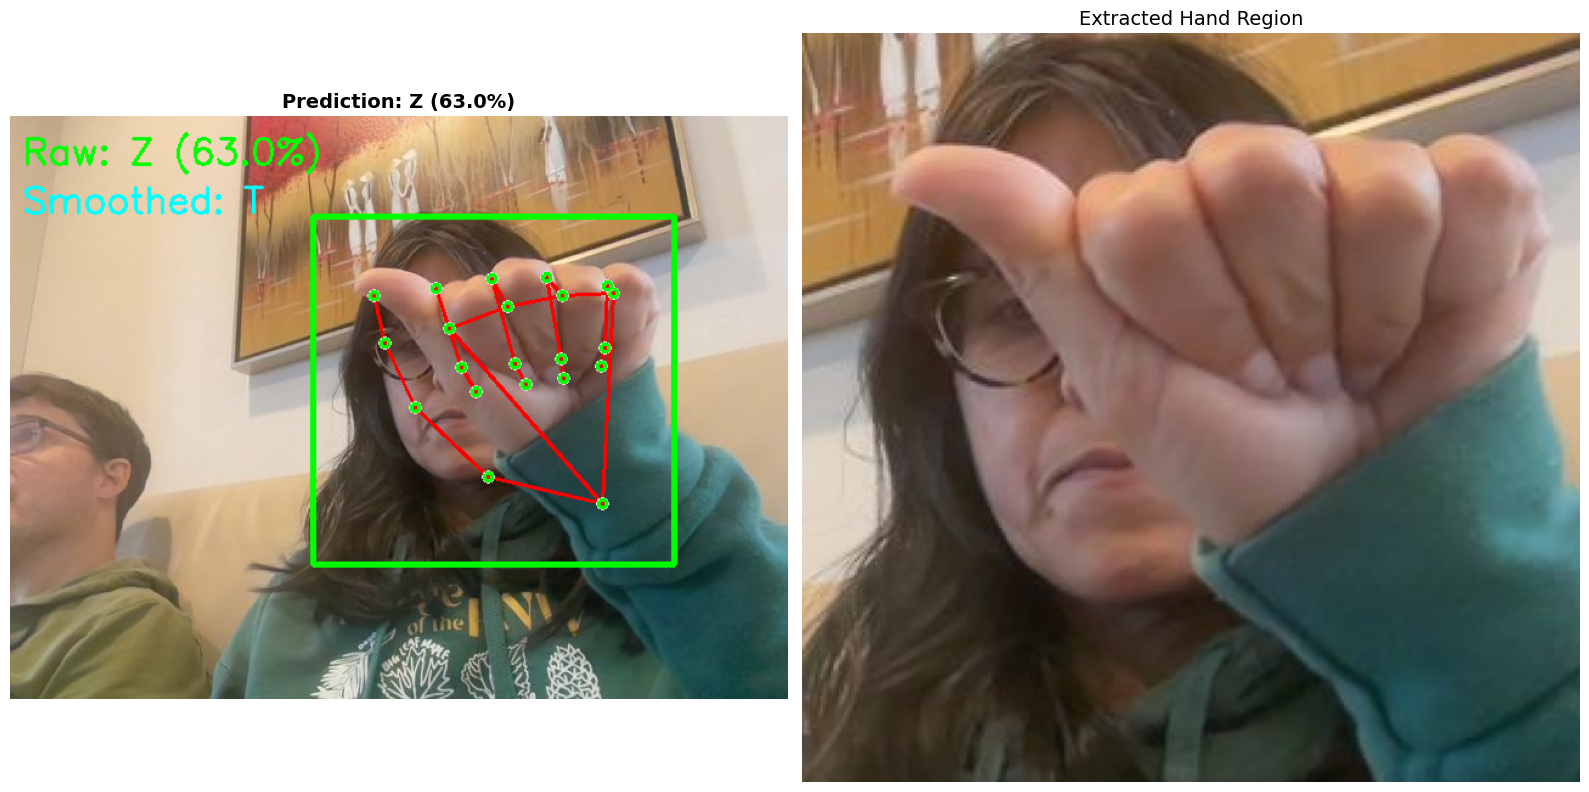


RAW PREDICTION: Z
CONFIDENCE: 62.96%
SMOOTHED: T

Top 5 predictions:
  1. Z        62.96% ███████████████████████████████
  2. Y        15.91% ███████
  3. X        13.05% ██████
  4. H         4.21% ██
  5. T         1.67% 


In [ ]:
 webcam_inference()

In [12]:
# ============================================================
# IMPROVED WEBCAM INFERENCE WITH BETTER PREPROCESSING
# ============================================================

def preprocess_hand_region_v2(hand_region):
    """
    Improved preprocessing with background removal and normalization
    """
    # Resize
    img_resized = cv2.resize(hand_region, (224, 224))

    # Convert to RGB
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)

    # Optional: Apply histogram equalization for better lighting
    img_yuv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2YUV)
    img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])
    img_rgb = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2RGB)

    # Add batch dimension
    img_array = np.expand_dims(img_rgb, axis=0)

    # EfficientNet preprocessing
    img_preprocessed = preprocess_input(img_array)

    return img_preprocessed

def get_hand_bbox_tight(hand_landmarks, frame_width, frame_height, padding=20):
    """
    Tighter bounding box to exclude face/background
    """
    x_coords = [landmark.x * frame_width for landmark in hand_landmarks.landmark]
    y_coords = [landmark.y * frame_height for landmark in hand_landmarks.landmark]

    # Use smaller padding to avoid capturing background
    x_min = max(0, int(min(x_coords)) - padding)
    x_max = min(frame_width, int(max(x_coords)) + padding)
    y_min = max(0, int(min(y_coords)) - padding)
    y_max = min(frame_height, int(max(y_coords)) + padding)

    # Make it square (like training data)
    width = x_max - x_min
    height = y_max - y_min
    size = max(width, height)

    # Center the square
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2

    x_min = max(0, x_center - size // 2)
    x_max = min(frame_width, x_center + size // 2)
    y_min = max(0, y_center - size // 2)
    y_max = min(frame_height, y_center + size // 2)

    return x_min, y_min, x_max, y_max

# Update the webcam function to use improved preprocessing
def webcam_inference_v2():
    """
    Improved webcam inference with better preprocessing
    """
    print("="*60)
    print("IMPROVED WEBCAM ASL RECOGNITION")
    print("="*60)
    print("Tips for better recognition:")
    print("- Use a plain background if possible")
    print("- Good lighting (face the light)")
    print("- Hold hand at arm's length from camera")
    print("- Keep hand fully in frame")
    print("="*60)

    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => setTimeout(resolve, 2000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', 0.8);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')

    display(js)
    data = eval_js('takePhoto()')

    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary))
    img_array = np.array(img)
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw landmarks
            mp_drawing.draw_landmarks(
                img_rgb,
                hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
                mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2)
            )

            # Get TIGHT bounding box
            h, w = img_bgr.shape[:2]
            x_min, y_min, x_max, y_max = get_hand_bbox_tight(hand_landmarks, w, h, padding=30)

            cv2.rectangle(img_rgb, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

            hand_region = img_bgr[y_min:y_max, x_min:x_max]

            if hand_region.size > 0:
                # Use IMPROVED preprocessing
                processed = preprocess_hand_region_v2(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                predicted_class = classes[predicted_idx]

                # Only add to smoother if high confidence
                if confidence > 0.8:  # Increased threshold
                    smoother.add_prediction(predicted_class)
                smoothed_prediction = smoother.get_smoothed_prediction()

                # Add text
                cv2.putText(img_rgb, f"Raw: {predicted_class} ({confidence:.1%})",
                           (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

                if smoothed_prediction:
                    cv2.putText(img_rgb, f"Smoothed: {smoothed_prediction}",
                               (10, 80), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

                # Display
                fig, axes = plt.subplots(2, 2, figsize=(14, 12))

                axes[0, 0].imshow(img_rgb)
                axes[0, 0].set_title(f"Prediction: {predicted_class} ({confidence:.1%})",
                                     fontsize=12, fontweight='bold')
                axes[0, 0].axis('off')

                axes[0, 1].imshow(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                axes[0, 1].set_title("Extracted Hand Region", fontsize=12)
                axes[0, 1].axis('off')

                # Show what the model actually sees after preprocessing
                hand_resized = cv2.resize(hand_region, (224, 224))
                axes[1, 0].imshow(cv2.cvtColor(hand_resized, cv2.COLOR_BGR2RGB))
                axes[1, 0].set_title("Resized (224x224)", fontsize=12)
                axes[1, 0].axis('off')

                # Compare with training sample
                sample_class = predicted_class if predicted_class in classes else 'A'
                sample_dir = os.path.join(actual_class_dir, sample_class)
                sample_img_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
                sample_img = plt.imread(sample_img_path)
                axes[1, 1].imshow(sample_img)
                axes[1, 1].set_title(f"Training Sample: {sample_class}", fontsize=12)
                axes[1, 1].axis('off')

                plt.tight_layout()
                plt.show()

                # Results
                print(f"\n{'='*60}")
                print(f"RAW PREDICTION: {predicted_class}")
                print(f"CONFIDENCE: {confidence:.2%}")
                if smoothed_prediction:
                    print(f"SMOOTHED: {smoothed_prediction}")
                print(f"{'='*60}")

                # Top 5
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for rank, idx in enumerate(top_5_idx, 1):
                    bar = "█" * int(prediction[0][idx] * 50)
                    symbol = "✓" if classes[idx] == predicted_class else " "
                    print(f"{symbol} {rank}. {classes[idx]:8s} {prediction[0][idx]:6.2%} {bar}")

                # Diagnostic info
                print(f"\nDiagnostic Info:")
                print(f"- Bounding box size: {x_max-x_min}x{y_max-y_min}")
                print(f"- Hand region size: {hand_region.shape}")
                print(f"- Confidence threshold for smoothing: 0.8")
                if confidence < 0.8:
                    print(f"⚠ Low confidence - not added to temporal smoother")

    else:
        print("✗ No hand detected")
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title("No hand detected", fontsize=16, color='red')
        plt.axis('off')
        plt.show()

print("✓ Improved webcam inference ready")
print("\nRun: webcam_inference_v2()")

✓ Improved webcam inference ready

Run: webcam_inference_v2()


In [13]:
# Reset smoother first
smoother.reset()

# Try improved version
webcam_inference_v2()

IMPROVED WEBCAM ASL RECOGNITION
Tips for better recognition:
- Use a plain background if possible
- Good lighting (face the light)
- Hold hand at arm's length from camera
- Keep hand fully in frame


NameError: name 'Javascript' is not defined

In [10]:
# ============================================================
# SOLUTION: HAND SEGMENTATION TO REMOVE BACKGROUND
# ============================================================

def segment_hand(img_bgr, hand_landmarks):
    """
    Create a mask of just the hand, remove background
    """
    h, w = img_bgr.shape[:2]

    # Create blank mask
    mask = np.zeros((h, w), dtype=np.uint8)

    # Get hand landmarks as polygon
    points = []
    for landmark in hand_landmarks.landmark:
        x = int(landmark.x * w)
        y = int(landmark.y * h)
        points.append([x, y])

    # Create convex hull around hand
    points = np.array(points)
    hull = cv2.convexHull(points)

    # Fill the hull to create mask
    cv2.fillConvexPoly(mask, hull, 255)

    # Dilate mask slightly to include edges
    kernel = np.ones((15, 15), np.uint8)
    mask = cv2.dilate(mask, kernel, iterations=1)

    # Apply mask to image
    hand_only = cv2.bitwise_and(img_bgr, img_bgr, mask=mask)

    # Replace background with white (like training data)
    background = np.ones_like(img_bgr) * 255
    mask_inv = cv2.bitwise_not(mask)
    background = cv2.bitwise_and(background, background, mask=mask_inv)
    hand_with_white_bg = cv2.add(hand_only, background)

    return hand_with_white_bg, mask

def webcam_with_segmentation():
    """
    Webcam inference with hand segmentation
    """
    print("="*60)
    print("WEBCAM WITH HAND SEGMENTATION (Background Removal)")
    print("="*60)

    js = Javascript('''
        async function takePhoto() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            await new Promise((resolve) => setTimeout(resolve, 2000));

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            const img = canvas.toDataURL('image/jpeg', 0.8);

            stream.getVideoTracks()[0].stop();
            div.remove();

            return img;
        }
    ''')

    display(js)
    data = eval_js('takePhoto()')

    binary = b64decode(data.split(',')[1])
    img = Image.open(BytesIO(binary))
    img_array = np.array(img)
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Segment hand (remove background)
            hand_segmented, mask = segment_hand(img_bgr, hand_landmarks)

            # Get bounding box
            h, w = img_bgr.shape[:2]
            x_min, y_min, x_max, y_max = get_hand_bbox_tight(hand_landmarks, w, h, padding=30)

            # Extract segmented hand region
            hand_region = hand_segmented[y_min:y_max, x_min:x_max]

            if hand_region.size > 0:
                # Preprocess
                processed = preprocess_hand_region(hand_region)

                # Predict
                prediction = model.predict(processed, verbose=0)
                predicted_idx = np.argmax(prediction)
                confidence = np.max(prediction)
                predicted_class = classes[predicted_idx]

                # Visualize
                fig, axes = plt.subplots(2, 3, figsize=(15, 10))

                # Original
                axes[0, 0].imshow(img_rgb)
                axes[0, 0].set_title("Original", fontsize=12)
                axes[0, 0].axis('off')

                # Mask
                axes[0, 1].imshow(mask, cmap='gray')
                axes[0, 1].set_title("Hand Mask", fontsize=12)
                axes[0, 1].axis('off')

                # Segmented
                axes[0, 2].imshow(cv2.cvtColor(hand_segmented, cv2.COLOR_BGR2RGB))
                axes[0, 2].set_title("Segmented (White BG)", fontsize=12)
                axes[0, 2].axis('off')

                # Cropped region
                axes[1, 0].imshow(cv2.cvtColor(hand_region, cv2.COLOR_BGR2RGB))
                axes[1, 0].set_title("Extracted Region", fontsize=12)
                axes[1, 0].axis('off')

                # Resized
                hand_resized = cv2.resize(hand_region, (224, 224))
                axes[1, 1].imshow(cv2.cvtColor(hand_resized, cv2.COLOR_BGR2RGB))
                axes[1, 1].set_title(f"Model Input\nPrediction: {predicted_class} ({confidence:.1%})",
                                     fontsize=12, fontweight='bold')
                axes[1, 1].axis('off')

                # Training sample comparison
                sample_dir = os.path.join(actual_class_dir, predicted_class)
                sample_img_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])
                sample_img = plt.imread(sample_img_path)
                axes[1, 2].imshow(sample_img)
                axes[1, 2].set_title(f"Training: {predicted_class}", fontsize=12)
                axes[1, 2].axis('off')

                plt.tight_layout()
                plt.show()

                print(f"\n{'='*60}")
                print(f"PREDICTION: {predicted_class}")
                print(f"CONFIDENCE: {confidence:.2%}")
                print(f"{'='*60}")

                # Top 5
                top_5_idx = np.argsort(prediction[0])[-5:][::-1]
                print("\nTop 5 predictions:")
                for rank, idx in enumerate(top_5_idx, 1):
                    bar = "█" * int(prediction[0][idx] * 50)
                    print(f"  {rank}. {classes[idx]:8s} {prediction[0][idx]:6.2%} {bar}")
    else:
        print("✗ No hand detected")
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.show()

print("✓ Hand segmentation function ready")
print("\nRun: webcam_with_segmentation()")

✓ Hand segmentation function ready

Run: webcam_with_segmentation()


WEBCAM WITH HAND SEGMENTATION (Background Removal)


<IPython.core.display.Javascript object>

FileNotFoundError: [Errno 2] No such file or directory: '/content/asl_data/asl_alphabet_train/asl_alphabet_train/W'

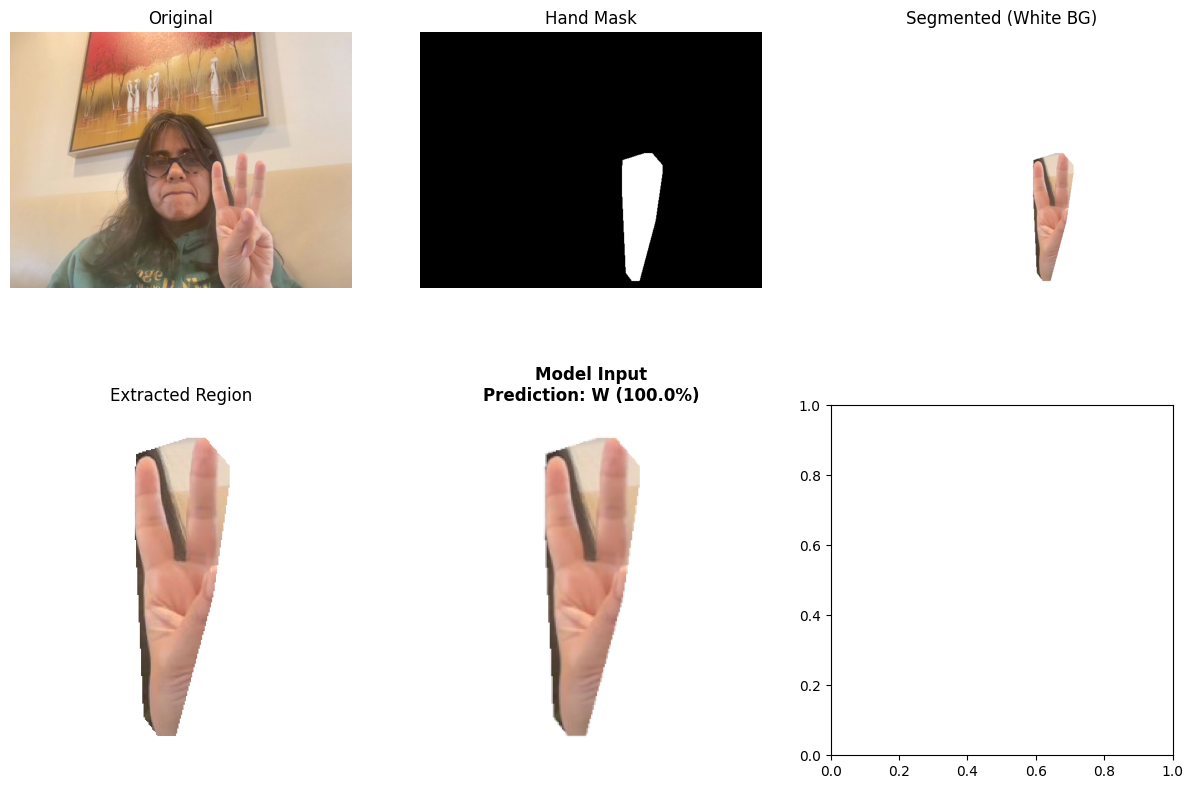

In [ ]:
webcam_with_segmentation()

In [39]:
import pickle
import json

# After Stage 1 completes
if history_stage1:
    # Save as pickle
    with open(f'{project_dir}/history_stage1.pkl', 'wb') as f:
        pickle.dump(history_stage1.history, f)

    # Also save as JSON (more portable)
    with open(f'{project_dir}/history_stage1.json', 'w') as f:
        json.dump(history_stage1.history, f)

    print("✓ Stage 1 history saved")

# After Stage 2 completes
with open(f'{project_dir}/history_stage2.pkl', 'wb') as f:
    pickle.dump(history_stage2.history, f)

with open(f'{project_dir}/history_stage2.json', 'w') as f:
    json.dump(history_stage2.history, f)

print("✓ Stage 2 history saved")

✓ Stage 2 history saved


WEBCAM WITH HAND SEGMENTATION (Background Removal)


<IPython.core.display.Javascript object>

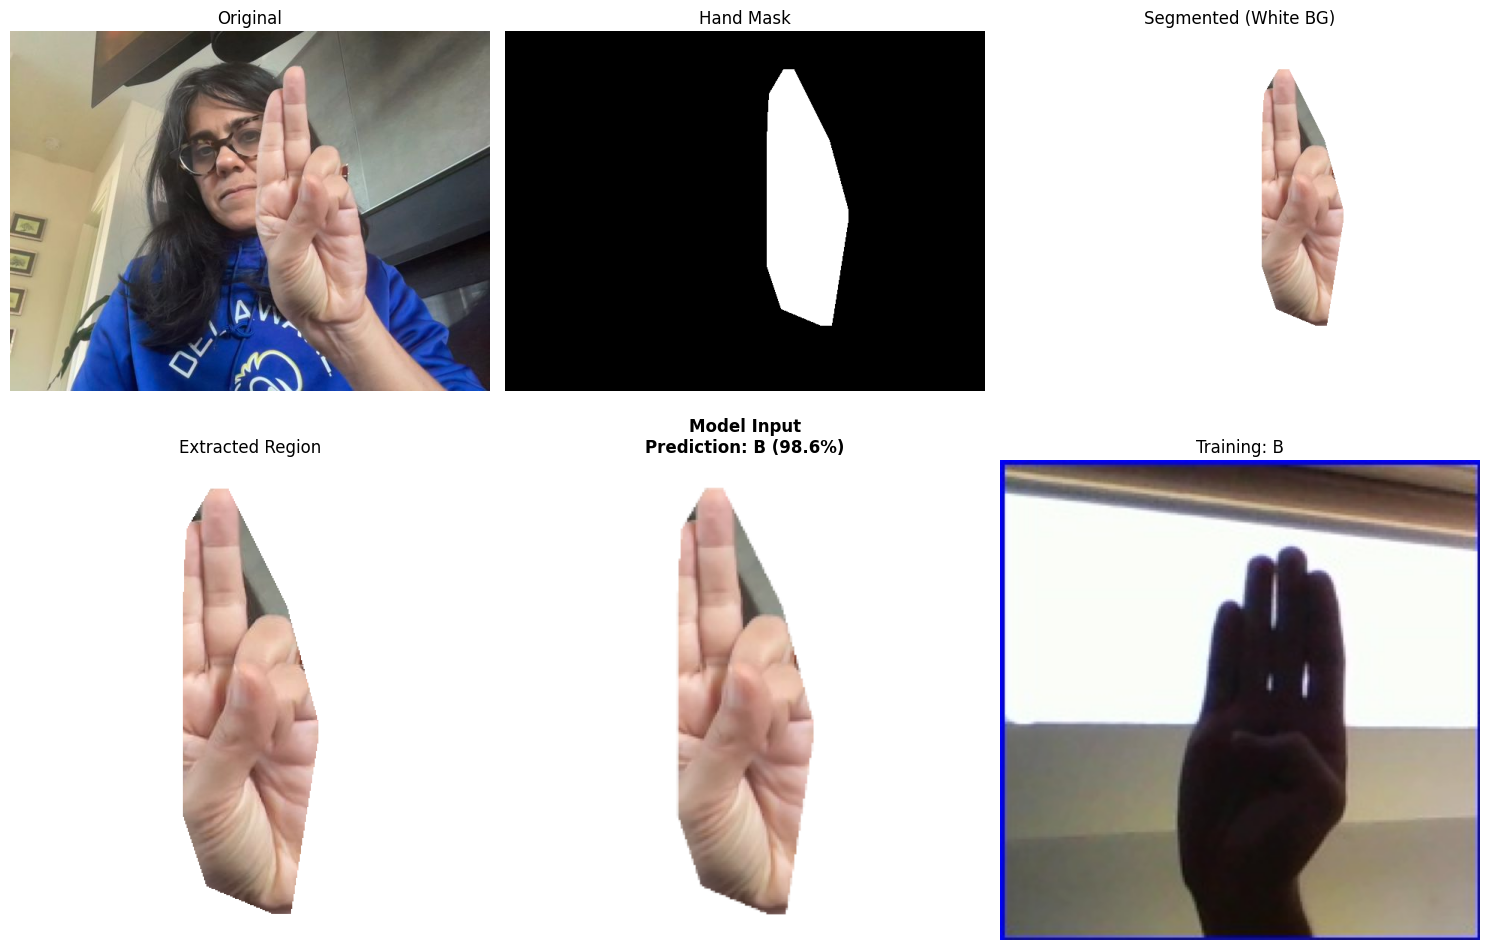


PREDICTION: B
CONFIDENCE: 98.58%

Top 5 predictions:
  1. B        98.58% █████████████████████████████████████████████████
  2. U         1.40% 
  3. R         0.01% 
  4. N         0.00% 
  5. I         0.00% 


In [40]:
webcam_with_segmentation()

CROSS-DATASET EVALUATION - AYURAJ ASL DATASET

Ayuraj dataset structure:
Found 27 classes: ['.DS_Store', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

RUNNING INFERENCE
⚠ Skipping .DS_Store - not in model classes

Class A: 70 images → Accuracy: 21.4% (15/70)

Class B: 70 images → Accuracy: 98.6% (69/70)

Class C: 70 images → Accuracy: 78.6% (55/70)

Class D: 70 images → Accuracy: 0.0% (0/70)

Class E: 70 images → Accuracy: 100.0% (70/70)

Class F: 70 images → Accuracy: 0.0% (0/70)

Class G: 70 images → Accuracy: 34.3% (24/70)

Class H: 70 images → Accuracy: 45.7% (32/70)

Class I: 70 images → Accuracy: 92.9% (65/70)

Class J: 70 images → Accuracy: 40.0% (28/70)

Class K: 70 images → Accuracy: 80.0% (56/70)

Class L: 70 images → Accuracy: 28.6% (20/70)

Class M: 70 images → Accuracy: 0.0% (0/70)

Class N: 70 images → Accuracy: 0.0% (0/70)

Class O: 70 images → Accuracy: 100.0% (70/70)

Class P: 70 image

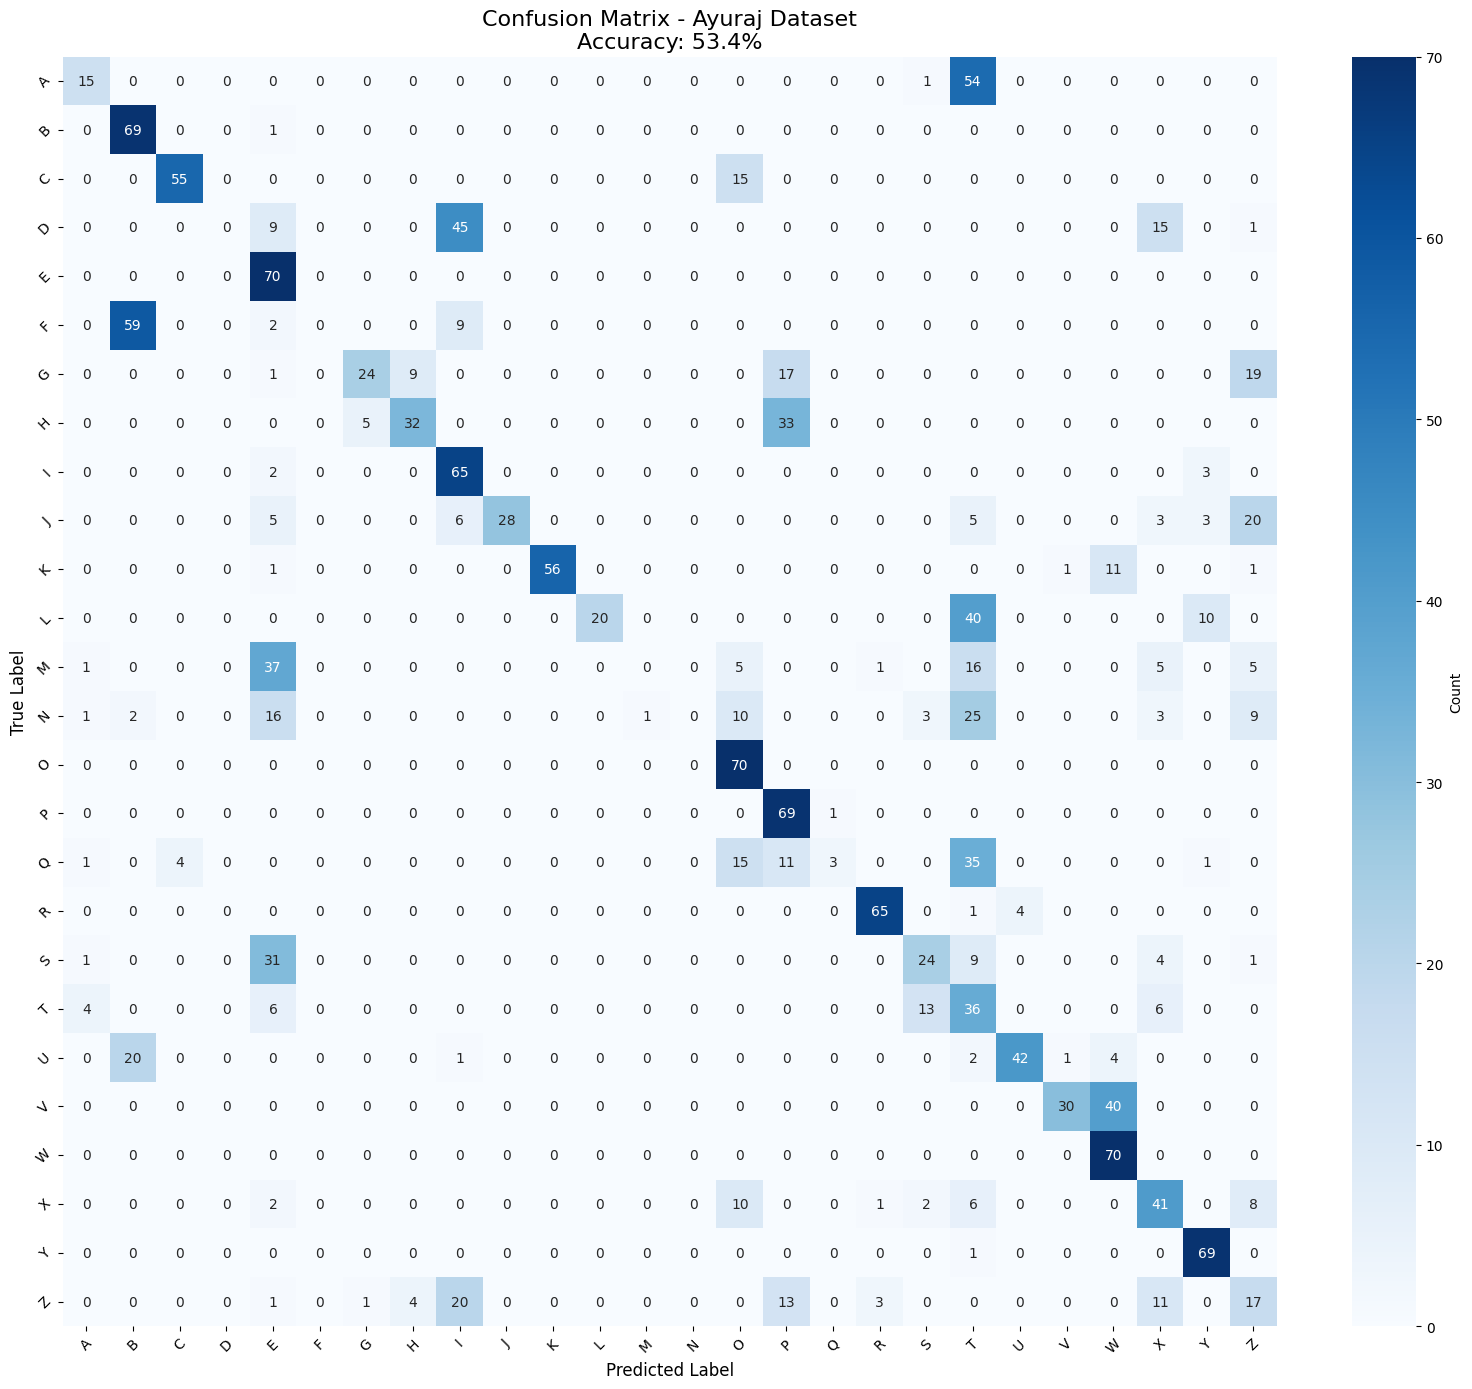


MOST CONFUSED SIGN PAIRS

Top 15 misclassifications:
 1. F → B:  59 times (84.3%)
 2. A → T:  54 times (77.1%)
 3. D → I:  45 times (64.3%)
 4. L → T:  40 times (57.1%)
 5. V → W:  40 times (57.1%)
 6. M → E:  37 times (52.9%)
 7. Q → T:  35 times (50.0%)
 8. H → P:  33 times (47.1%)
 9. S → E:  31 times (44.3%)
10. N → T:  25 times (35.7%)
11. J → Z:  20 times (28.6%)
12. U → B:  20 times (28.6%)
13. Z → I:  20 times (28.6%)
14. G → Z:  19 times (27.1%)
15. G → P:  17 times (24.3%)

845 total misclassifications (46.6%)

Sample errors (first 10):
  True: A        → Predicted: T        (53.3%)
  True: A        → Predicted: T        (99.7%)
  True: A        → Predicted: T        (75.1%)
  True: A        → Predicted: T        (71.9%)
  True: A        → Predicted: T        (57.2%)
  True: A        → Predicted: T        (93.7%)
  True: A        → Predicted: T        (66.4%)
  True: A        → Predicted: T        (99.4%)
  True: A        → Predicted: T        (57.9%)
  True: A        → Pred

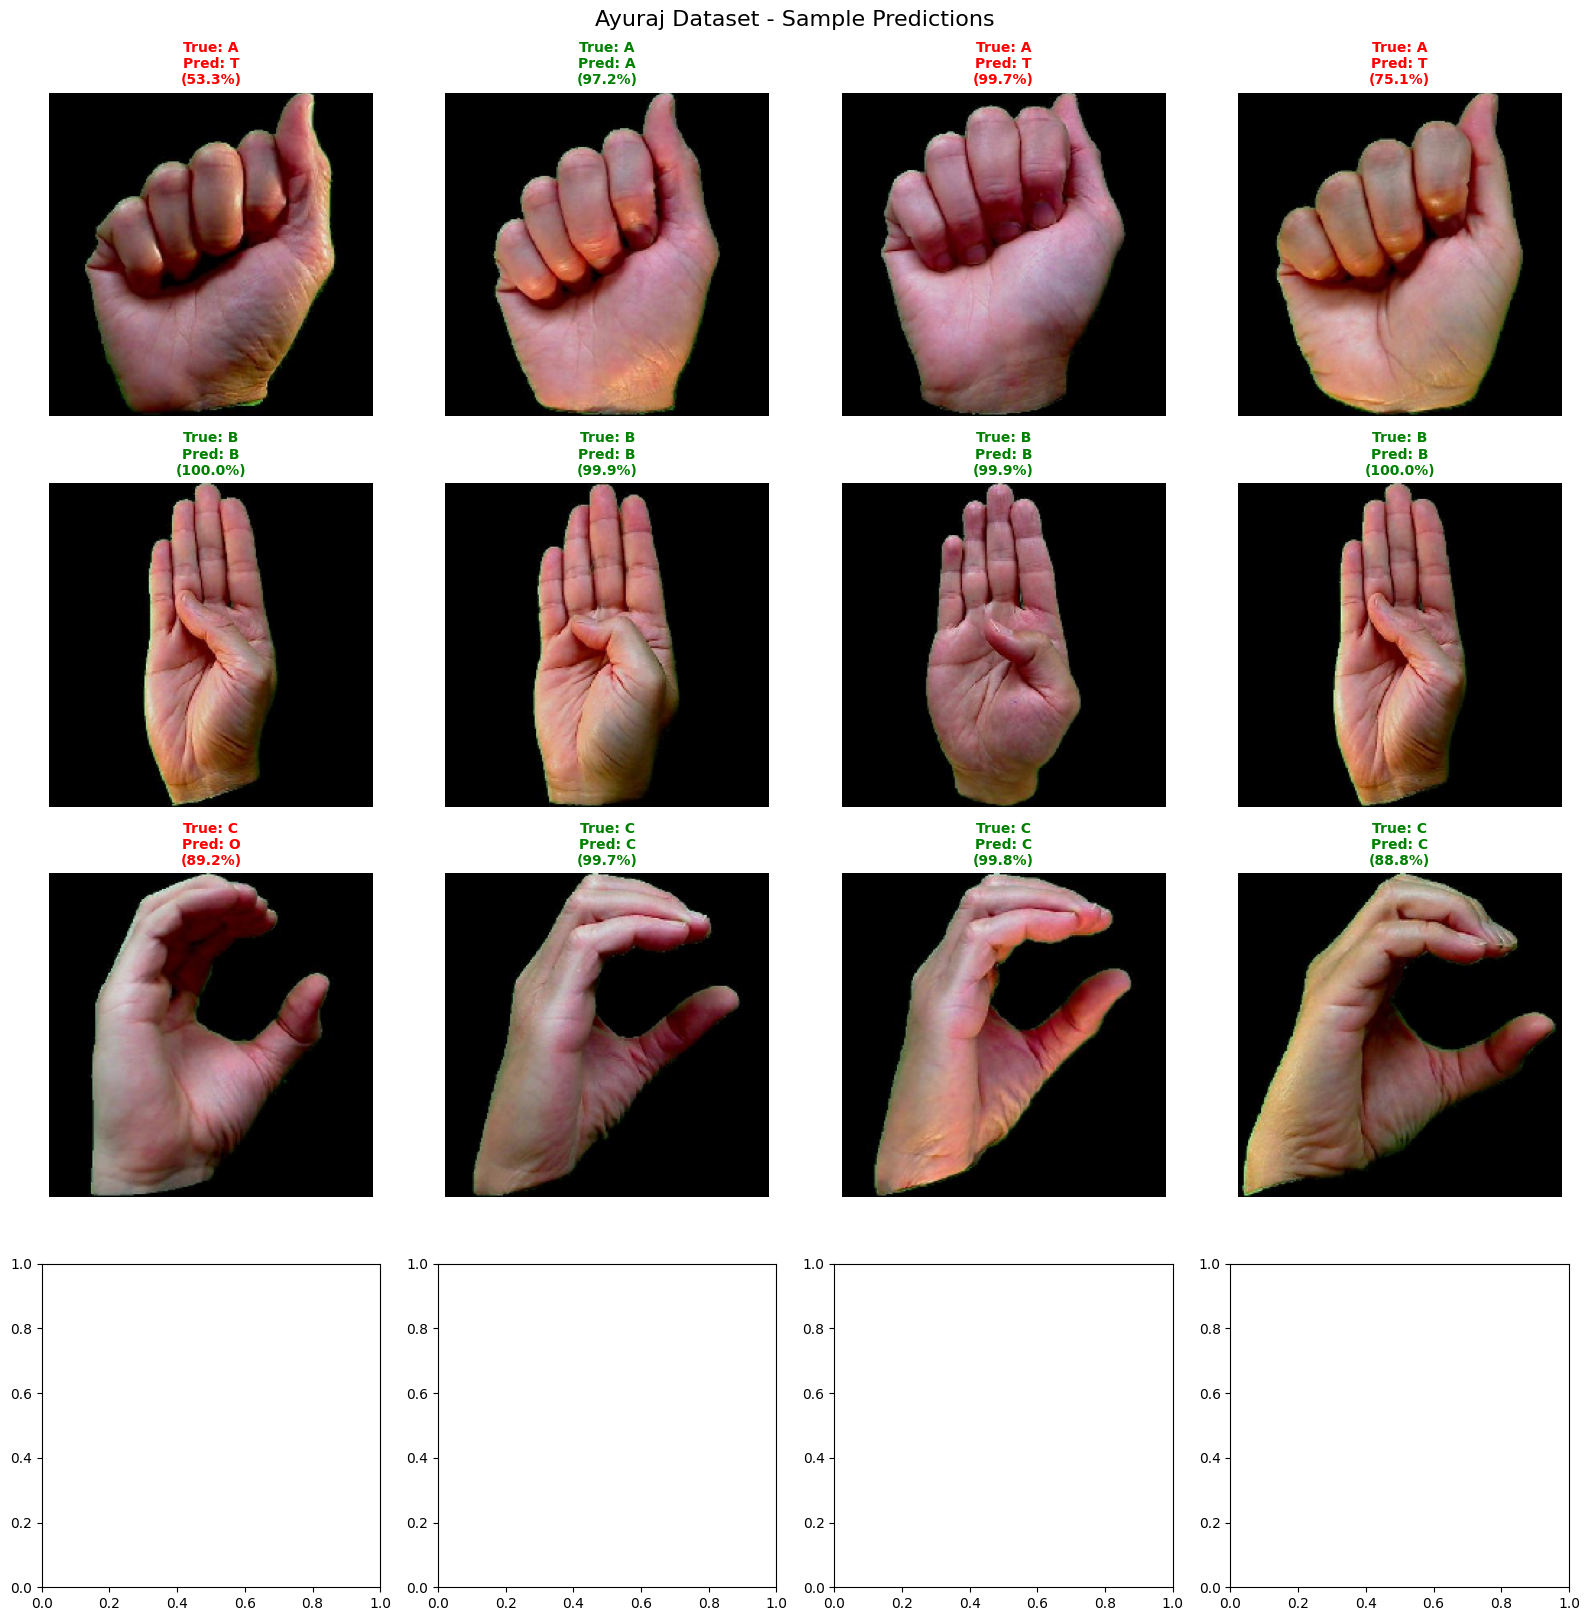


PERFORMANCE COMPARISON
Training/Test (Kaggle):  100.0%
Cross-dataset (Ayuraj):  53.4%
Performance drop:        46.6 percentage points


In [44]:
# ============================================================
# TEST ON AYURAJ DATASET (UPLOADED TO COLAB)
# ============================================================

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import defaultdict

print("="*60)
print("CROSS-DATASET EVALUATION - AYURAJ ASL DATASET")
print("="*60)

# Paths
ayuraj_test_dir = '/content/test_dataset/test_asl_dataset'
# model_path = f'{project_dir}/models_fixed/asl_model_best.keras'

# # Load model
# print(f"\nLoading model: {model_path}")
# model = tf.keras.models.load_model(model_path)
# print("✓ Model loaded")

# Get classes from your training
# classes = sorted(os.listdir('/content/asl_data/asl_alphabet_train'))
# print(f"✓ {len(classes)} classes: {classes}")

# Check Ayuraj dataset structure
print(f"\nAyuraj dataset structure:")
ayuraj_classes = sorted(os.listdir(ayuraj_test_dir))
print(f"Found {len(ayuraj_classes)} classes: {ayuraj_classes}")

# ============================================================
# RUN INFERENCE
# ============================================================

results = []
max_per_class = 100  # Limit for speed

print("\n" + "="*60)
print("RUNNING INFERENCE")
print("="*60)

for class_name in ayuraj_classes:
    # Convert lowercase to uppercase to match your model
    true_class = class_name.upper()

    if true_class not in classes:
        print(f"⚠ Skipping {class_name} - not in model classes")
        continue

    class_dir = os.path.join(ayuraj_test_dir, class_name)

    if not os.path.isdir(class_dir):
        continue

    # Get images
    image_files = [f for f in os.listdir(class_dir)
                   if f.endswith(('.jpg', '.png', '.jpeg', '.JPG', '.PNG'))][:max_per_class]

    print(f"\nClass {true_class}: {len(image_files)} images", end='')

    class_correct = 0

    for img_file in image_files:
        img_path = os.path.join(class_dir, img_file)

        try:
            # Load and preprocess
            img = load_img(img_path, target_size=(224, 224))
            img_array = img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)

            # Predict
            pred = model.predict(img_array, verbose=0)
            predicted_idx = np.argmax(pred)
            confidence = np.max(pred)
            predicted_class = classes[predicted_idx]

            is_correct = predicted_class == true_class
            if is_correct:
                class_correct += 1

            results.append({
                'true': true_class,
                'predicted': predicted_class,
                'confidence': confidence,
                'correct': is_correct
            })

        except Exception as e:
            print(f"\n  Error processing {img_file}: {e}")
            continue

    class_acc = class_correct / len(image_files) if image_files else 0
    print(f" → Accuracy: {class_acc:.1%} ({class_correct}/{len(image_files)})")

# ============================================================
# RESULTS SUMMARY
# ============================================================

correct = sum(1 for r in results if r['correct'])
total = len(results)
accuracy = correct / total

print("\n" + "="*60)
print("CROSS-DATASET RESULTS")
print("="*60)
print(f"Total predictions: {total}")
print(f"Correct: {correct}")
print(f"Accuracy: {accuracy:.2%}")
print(f"Average confidence: {np.mean([r['confidence'] for r in results]):.2%}")

# ============================================================
# PER-CLASS ACCURACY
# ============================================================

class_stats = defaultdict(lambda: {'correct': 0, 'total': 0})

for r in results:
    class_stats[r['true']]['total'] += 1
    if r['correct']:
        class_stats[r['true']]['correct'] += 1

print("\n" + "="*60)
print("PER-CLASS ACCURACY")
print("="*60)

for cls in sorted(class_stats.keys()):
    stats = class_stats[cls]
    acc = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
    bar = "█" * int(acc * 40)
    print(f"{cls:8s}: {stats['correct']:3d}/{stats['total']:3d} ({acc:6.1%}) {bar}")

# ============================================================
# CONFUSION MATRIX
# ============================================================

true_labels = [r['true'] for r in results]
pred_labels = [r['predicted'] for r in results]
unique_classes = sorted(set(true_labels))

cm = confusion_matrix(true_labels, pred_labels, labels=unique_classes)

plt.figure(figsize=(16, 14))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_classes, yticklabels=unique_classes,
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - Ayuraj Dataset\nAccuracy: {accuracy:.1%}', fontsize=16)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# ============================================================
# MOST CONFUSED PAIRS
# ============================================================

print("\n" + "="*60)
print("MOST CONFUSED SIGN PAIRS")
print("="*60)

confusion_pairs = []
for i, true_cls in enumerate(unique_classes):
    for j, pred_cls in enumerate(unique_classes):
        if i != j and cm[i, j] > 0:
            confusion_pairs.append((true_cls, pred_cls, cm[i, j]))

confusion_pairs.sort(key=lambda x: x[2], reverse=True)

if confusion_pairs:
    print("\nTop 15 misclassifications:")
    for rank, (true_cls, pred_cls, count) in enumerate(confusion_pairs[:15], 1):
        pct = count / class_stats[true_cls]['total'] * 100
        print(f"{rank:2d}. {true_cls} → {pred_cls}: {count:3d} times ({pct:.1f}%)")

# ============================================================
# SAMPLE MISCLASSIFICATIONS
# ============================================================

errors = [r for r in results if not r['correct']]

print(f"\n{len(errors)} total misclassifications ({len(errors)/total*100:.1f}%)")
print("\nSample errors (first 10):")
for err in errors[:10]:
    print(f"  True: {err['true']:8s} → Predicted: {err['predicted']:8s} ({err['confidence']:.1%})")

# ============================================================
# VISUALIZE PREDICTIONS
# ============================================================

print("\nGenerating visualization...")

fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.flatten()

sample_idx = 0

for class_name in ayuraj_classes[:4]:  # First 4 classes
    true_class = class_name.upper()

    if true_class not in classes:
        continue

    class_dir = os.path.join(ayuraj_test_dir, class_name)
    images = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))][:4]

    for img_file in images:
        if sample_idx >= 16:
            break

        img_path = os.path.join(class_dir, img_file)

        # Load
        img = load_img(img_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_display = img_array.astype('uint8')

        # Predict
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        pred = model.predict(img_array, verbose=0)
        predicted_class = classes[np.argmax(pred)]
        confidence = np.max(pred)

        # Display
        axes[sample_idx].imshow(img_display)
        color = 'green' if predicted_class == true_class else 'red'
        axes[sample_idx].set_title(
            f"True: {true_class}\nPred: {predicted_class}\n({confidence:.1%})",
            color=color, fontsize=10, fontweight='bold'
        )
        axes[sample_idx].axis('off')

        sample_idx += 1

plt.tight_layout()
plt.suptitle('Ayuraj Dataset - Sample Predictions', fontsize=16, y=1.01)
plt.show()

# ============================================================
# FINAL COMPARISON
# ============================================================

print("\n" + "="*60)
print("PERFORMANCE COMPARISON")
print("="*60)
print(f"Training/Test (Kaggle):  100.0%")
print(f"Cross-dataset (Ayuraj):  {accuracy:.1%}")
print(f"Performance drop:        {(1 - accuracy)*100:.1f} percentage points")
print("="*60)